In [1]:
from IPython.display import display
import IPython
import pandas as pd
from pandas import Series
import numpy as np
from random import randrange

from matplotlib import pyplot
import matplotlib.pyplot as plt
# from statsmodels.tsa.seasonal import seasonal_decompose

# np.float_ = np.float64
# from prophet import Prophet

import math
from typing import Any, List, Dict, AnyStr, Optional
from pathlib import Path
from glob import glob

from utils.dataset import MarketData, DataPreprocessor, Plotting
from utils.windowgenerator import WindowGenerator, compile_and_fit

import tensorflow as tf

%load_ext autoreload
%autoreload 2

In [3]:
import pandas as pd
import talib

def calculate_rolling_mean(df, column_name, window):
    """
    Calculate the rolling mean (SMA) for a specific column in a DataFrame.
    
    Parameters:
    df (pd.DataFrame): The input DataFrame containing the time series data.
    column_name (str): The column name on which to calculate the rolling mean.
    window (int): The window size for calculating the rolling mean.
    
    Returns:
    pd.Series: A Pandas Series containing the rolling mean values.
    """
    return df[column_name].rolling(window=window).mean()

def calculate_ema(df, column_name, window):
    """
    Calculate the Exponential Moving Average (EMA) for a specific column in a DataFrame.
    
    Parameters:
    df (pd.DataFrame): The input DataFrame containing the time series data.
    column_name (str): The column name on which to calculate the EMA.
    window (int): The window size for calculating the EMA.
    
    Returns:
    pd.Series: A Pandas Series containing the EMA values.
    """
    return talib.EMA(df[column_name], timeperiod=window)

# Example usage:
# Assume df is your DataFrame containing time series data with a column named 'price'

# Calculate a 20-day rolling mean for the 'price' column

## Dataset

### Loading Dataset

In [4]:
cot_df, auction_df, eua_df, ta_df, fundamentals_df = MarketData.latest(Path('data'))
cot_df = cot_df.set_index('Date').resample('W', origin='end').mean().reset_index()
auction_df = auction_df.set_index('Date').resample('D').mean().reset_index()


In [5]:
auction_df = auction_df[7:]
auction_df.loc[:, 'Premium/discount-settle'] = auction_df['Premium/discount-settle'].ffill()
auction_df.loc[:, ['Auc Price', 'Median Price', 'Cover Ratio', 'Spot Value',
'Auction Spot Diff', 'Median Spot Diff', 'Premium/discount-settle']] = auction_df[['Auc Price', 'Median Price', 'Cover Ratio', 'Spot Value', 
                                                                                          'Auction Spot Diff', 'Median Spot Diff', 'Premium/discount-settle']].ffill()

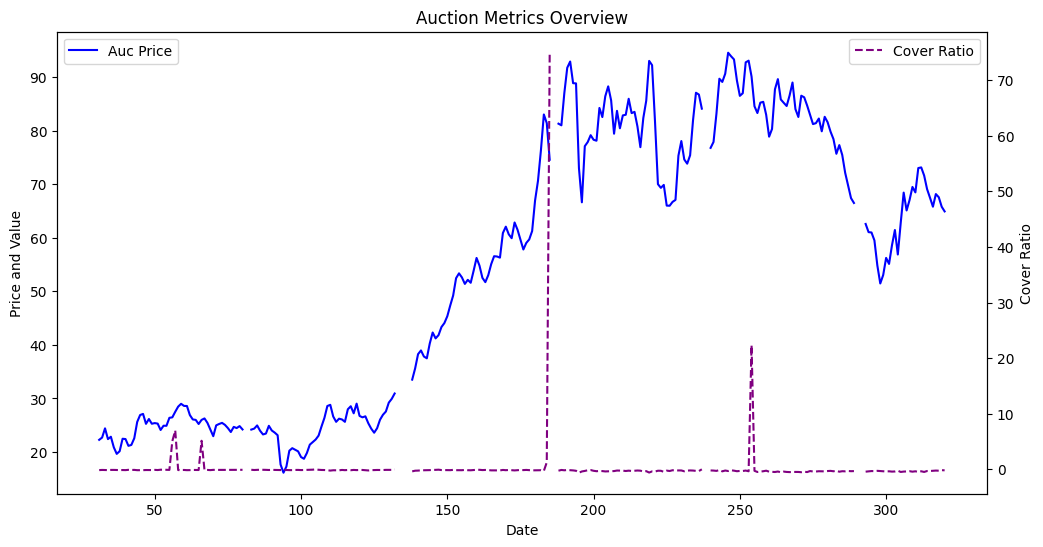

In [48]:
import matplotlib.pyplot as plt

# Create a figure and a set of subplots
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot 'Auc Price', 'Median Price', 'Spot Value' on primary y-axis
ax1.plot(auction_df[auction_df.set_index('Date').index.year > 2018]['Auc Price'], label='Auc Price', color='blue')
# ax1.plot(auction_df[auction_df.index.year > 2018]['Median Price'], label='Median Price', color='green')
# ax1.plot(auction_df[auction_df.index.year > 2018]['Spot Value'], label='Spot Value', color='red')

# Set labels and title
ax1.set_xlabel('Date')  # Assuming the index of auction_df is the date
ax1.set_ylabel('Price and Value')
ax1.set_title('Auction Metrics Overview')
ax1.legend(loc='upper left')

# Create a second y-axis for 'Cover Ratio'
ax2 = ax1.twinx()
ax2.plot(auction_df[auction_df.set_index('Date').index.year > 2018]['Median Spot Diff'], label='Cover Ratio', color='purple', linestyle='--')
ax2.set_ylabel('Cover Ratio')

# Adding legend for the second axis
ax2.legend(loc='upper right')

# Show plot
plt.show()

### Merging Dataset

In [181]:
def merge_auc_cot(auction_df, cot_df):
    merged_df = pd.merge_asof(auction_df, cot_df, on='Date', direction='backward')
    merged_df.ffill(inplace=True)
    merged_df.bfill(inplace=True)
    merged_df.drop(["Spot Value", "Median Price"], axis=1, inplace=True)
    merged_df.loc[:, 'Pct_Change_Auc_Price'] = merged_df['Auc Price'].pct_change() * 100
    merged_df = merged_df.dropna(subset=['Pct_Change_Auc_Price'])

    merged_df['7 MA Premium/discount-settle'] = calculate_rolling_mean(merged_df, 'Premium/discount-settle', 7)
    merged_df['20 MA Premium/discount-settle'] = calculate_rolling_mean(merged_df, 'Premium/discount-settle', 20)
    merged_df['7 EMA Premium/discount-settle'] = calculate_ema(merged_df, 'Premium/discount-settle', 7)
    merged_df['20 EMA Premium/discount-settle'] = calculate_ema(merged_df, 'Premium/discount-settle', 20)

    merged_df['delta_auc'] = merged_df['Auc Price'].diff(2)
    merged_df['delta_auc_4'] = merged_df['Auc Price'].diff(4)
    merged_df['auc_T-2'] = merged_df['Auc Price'].shift(2)
    merged_df['auc_T-4'] = merged_df['Auc Price'].shift(4)

    merged_df['delta_ls'] = merged_df['Long/Short'].diff(2)
    merged_df['delta_ls_4'] = merged_df['Long/Short'].diff(4)
    merged_df['ls_T-2'] = merged_df['Auc Price'].shift(2)
    merged_df['ls_T-4'] = merged_df['Auc Price'].shift(4)


    merged_df.dropna(inplace=True)

    return merged_df

merged_df = merge_auc_cot(auction_df, cot_df)

In [182]:
def merge_auc_cot(auction_df, cot_df):
    # Merge DataFrames
    merged_df = pd.merge_asof(auction_df, cot_df, on='Date', direction='backward')
    merged_df.ffill(inplace=True)
    merged_df.bfill(inplace=True)
    
    # Drop unnecessary columns
    merged_df.drop(["Spot Value", "Median Price"], axis=1, inplace=True)
    
    # Calculate percentage change in Auc Price
    merged_df.loc[:, 'Pct_Change_Auc_Price'] = merged_df['Auc Price'].pct_change() * 100
    merged_df = merged_df.dropna(subset=['Pct_Change_Auc_Price'])

    ### Rolling Means and Exponential Moving Averages
    merged_df['7 MA Premium/discount-settle'] = ta.SMA(merged_df['Premium/discount-settle'], timeperiod=7)
    merged_df['20 MA Premium/discount-settle'] = ta.SMA(merged_df['Premium/discount-settle'], timeperiod=20)
    merged_df['7 EMA Premium/discount-settle'] = ta.EMA(merged_df['Premium/discount-settle'], timeperiod=7)
    merged_df['20 EMA Premium/discount-settle'] = ta.EMA(merged_df['Premium/discount-settle'], timeperiod=20)
    
    merged_df['7 MA net_speculators'] = ta.SMA(merged_df['net_speculators'], timeperiod=7)
    merged_df['20 MA net_speculators'] = ta.SMA(merged_df['net_speculators'], timeperiod=20)
    merged_df['7 EMA net_speculators'] = ta.EMA(merged_df['net_speculators'], timeperiod=7)
    merged_df['20 EMA net_speculators'] = ta.EMA(merged_df['net_speculators'], timeperiod=20)
    
    merged_df['7 MA spec_long_%'] = ta.SMA(merged_df['spec_long_%'], timeperiod=7)
    merged_df['20 MA spec_long_%'] = ta.SMA(merged_df['spec_long_%'], timeperiod=20)
    
    merged_df['7 EMA spec_long_%'] = ta.EMA(merged_df['spec_long_%'], timeperiod=7)
    merged_df['20 EMA spec_long_%'] = ta.EMA(merged_df['spec_long_%'], timeperiod=20)

    ### Lagged Features
    merged_df['delta_auc'] = merged_df['Auc Price'].diff(2)
    merged_df['delta_auc_4'] = merged_df['Auc Price'].diff(4)
    merged_df['auc_T-2'] = merged_df['Auc Price'].shift(2)
    merged_df['auc_T-4'] = merged_df['Auc Price'].shift(4)

    merged_df['delta_ls'] = merged_df['Long/Short'].diff(2)
    merged_df['delta_ls_4'] = merged_df['Long/Short'].diff(4)
    merged_df['ls_T-2'] = merged_df['Long/Short'].shift(2)
    merged_df['ls_T-4'] = merged_df['Long/Short'].shift(4)
    
    merged_df['delta_net_spec_2'] = merged_df['net_speculators'].diff(2)
    merged_df['delta_net_spec_4'] = merged_df['net_speculators'].diff(4)
    merged_df['net_spec_T-2'] = merged_df['net_speculators'].shift(2)
    merged_df['net_spec_T-4'] = merged_df['net_speculators'].shift(4)

    merged_df['delta_spec_long_2'] = merged_df['spec_long_%'].diff(2)
    merged_df['delta_spec_long_4'] = merged_df['spec_long_%'].diff(4)
    merged_df['spec_long_T-2'] = merged_df['spec_long_%'].shift(2)
    merged_df['spec_long_T-4'] = merged_df['spec_long_%'].shift(4)

    merged_df['delta_spec_short_2'] = merged_df['spec_short_%'].diff(2)
    merged_df['delta_spec_short_4'] = merged_df['spec_short_%'].diff(4)
    merged_df['spec_short_T-2'] = merged_df['spec_short_%'].shift(2)
    merged_df['spec_short_T-4'] = merged_df['spec_short_%'].shift(4)

    ### Momentum and Volatility Features
    merged_df['RSI_Auc_Price'] = ta.RSI(merged_df['Auc Price'], timeperiod=14)
    merged_df['Momentum_Auc_Price'] = ta.MOM(merged_df['Auc Price'], timeperiod=10)
    merged_df['Volatility_Auc_Price'] = ta.STDDEV(merged_df['Auc Price'], timeperiod=5, nbdev=1)
    
    ### Additional Indicators
    merged_df['Upper_Band'], merged_df['Middle_Band'], merged_df['Lower_Band'] = ta.BBANDS(merged_df['Auc Price'], timeperiod=20, nbdevup=2, nbdevdn=2, matype=0)
    merged_df['MACD_Auc_Price'], _, _ = ta.MACD(merged_df['Auc Price'], fastperiod=12, slowperiod=26, signalperiod=9)
    merged_df['ATR'] = ta.ATR(merged_df['Auc Price'], merged_df['Auc Price'], merged_df['Auc Price'], timeperiod=14)

    merged_df.dropna(inplace=True)

    return merged_df



In [183]:
print(f"COT Cols: {cot_df.columns}")
print(f"AUC Cols: {auction_df.columns}")

COT Cols: Index(['Date', 'net_speculators', 'spec_long_%', 'spec_short_%', 'Long/Short'], dtype='object')
AUC Cols: Index(['Date', 'Auc Price', 'Median Price', 'Cover Ratio', 'Spot Value',
       'Auction Spot Diff', 'Median Spot Diff', 'Premium/discount-settle'],
      dtype='object')


In [184]:
# Example usage
merged_df = merge_auc_cot(auction_df, cot_df)

NameError: name 'ta' is not defined

In [53]:
merged_df.head()

,Date,Auc Price,Cover Ratio,Auction Spot Diff,Median Spot Diff,Premium/discount-settle,net_speculators,spec_long_%,spec_short_%,Long/Short,...,spec_short_T-2,spec_short_T-4,RSI_Auc_Price,Momentum_Auc_Price,Volatility_Auc_Price,Upper_Band,Middle_Band,Lower_Band,MACD_Auc_Price,ATR
34,2019-02-03,22.4060,2.3440,-0.060,-0.1320,-0.002713,47168.55,7.08,2.23,3.174888,...,2.12,1.90,60.041437,2.913500,0.791352,24.850267,20.871950,16.893633,1.530430,0.911242
35,2019-02-10,22.8475,2.1625,-0.010,-0.1000,-0.000426,43985.39,6.82,2.29,2.978166,...,2.16,2.19,61.477164,3.237500,0.771178,25.032318,20.961825,16.891332,1.479787,0.877689
36,2019-02-17,20.8740,2.0060,-0.020,-0.0980,-0.000962,40686.83,6.56,2.36,2.779661,...,2.23,2.12,52.411855,0.966500,1.128168,25.027593,20.956925,16.886257,1.265816,0.955961
37,2019-02-24,19.6500,2.7175,-0.045,-0.1175,-0.002347,35458.73,6.20,2.54,2.440945,...,2.29,2.16,47.712582,-1.156667,1.642581,24.993177,20.883925,16.774673,0.986109,0.975107
38,2019-03-03,20.1480,2.2380,-0.004,-0.1280,-0.000140,35967.52,6.16,2.38,2.588235,...,2.36,2.23,49.689078,-3.252000,1.247643,24.984153,20.865025,16.745897,0.795453,0.941028


In [54]:
print(merged_df.shape)
merged_df.head()

(287, 51)


,Date,Auc Price,Cover Ratio,Auction Spot Diff,Median Spot Diff,Premium/discount-settle,net_speculators,spec_long_%,spec_short_%,Long/Short,...,spec_short_T-2,spec_short_T-4,RSI_Auc_Price,Momentum_Auc_Price,Volatility_Auc_Price,Upper_Band,Middle_Band,Lower_Band,MACD_Auc_Price,ATR
34,2019-02-03,22.4060,2.3440,-0.060,-0.1320,-0.002713,47168.55,7.08,2.23,3.174888,...,2.12,1.90,60.041437,2.913500,0.791352,24.850267,20.871950,16.893633,1.530430,0.911242
35,2019-02-10,22.8475,2.1625,-0.010,-0.1000,-0.000426,43985.39,6.82,2.29,2.978166,...,2.16,2.19,61.477164,3.237500,0.771178,25.032318,20.961825,16.891332,1.479787,0.877689
36,2019-02-17,20.8740,2.0060,-0.020,-0.0980,-0.000962,40686.83,6.56,2.36,2.779661,...,2.23,2.12,52.411855,0.966500,1.128168,25.027593,20.956925,16.886257,1.265816,0.955961
37,2019-02-24,19.6500,2.7175,-0.045,-0.1175,-0.002347,35458.73,6.20,2.54,2.440945,...,2.29,2.16,47.712582,-1.156667,1.642581,24.993177,20.883925,16.774673,0.986109,0.975107
38,2019-03-03,20.1480,2.2380,-0.004,-0.1280,-0.000140,35967.52,6.16,2.38,2.588235,...,2.36,2.23,49.689078,-3.252000,1.247643,24.984153,20.865025,16.745897,0.795453,0.941028


### Train & Test Data

In [67]:
def train_test_data(merged_df, features = []):
    if len(features) == 0:
        FEATURES = ['Auc Price', 'Cover Ratio', 'Auction Spot Diff',
       'Median Spot Diff', 'Premium/discount-settle', 'net_speculators',
       'spec_long_%', 'spec_short_%', 'Long/Short', 'Pct_Change_Auc_Price',
       'delta_auc', 'delta_auc_4', 'auc_T-2', 'auc_T-4', 'delta_ls',
       'delta_ls_4', 'ls_T-2', 'ls_T-4']
        
    else: 
        FEATURES = [feature for feature in features if feature != 'Date']
    train_df = merged_df[merged_df['Date'] <
                        "2024-02-01"].copy().set_index('Date')[FEATURES].copy()
    
    val_df = merged_df[(merged_df['Date'] >= "2024-02-01") & (merged_df['Date'] < "2024-05-01")].copy().set_index('Date')[FEATURES].copy()
    
    test_df = merged_df[merged_df['Date'] >= "2024-05-01"].copy().set_index('Date')[FEATURES].copy()

    return train_df, test_df, val_df

train_df, test_df, val_df = train_test_data(merged_df)


#### Dataset Normalization

In [68]:
def normalize(train_df, test_df, val_df):
    train_mean = train_df.mean()
    train_std = train_df.std()

    train_df = (train_df - train_mean) / train_std
    val_df = (val_df - train_mean) / train_std
    test_df = (test_df - train_mean) / train_std

    return train_df, test_df, val_df

# Normalize
train_df, test_df, val_df = normalize(train_df, test_df, val_df)
num_features = train_df.shape[1]    

In [6]:
cot_df, auction_df, eua_df, ta_df, fundamentals_df = MarketData.latest(Path('data'))
cot_df = cot_df.set_index('Date').resample('W', origin='end').mean().reset_index()
auction_df = auction_df.set_index('Date').resample('D').mean().reset_index()

# Merge and preprocess data
merged_df = MarketData.merge_auc_cot(auction_df, cot_df)
merged_df = DataPreprocessor.MA_features(merged_df)
merged_df = merged_df.dropna()

# Define features and labels
FEATURES = merged_df.columns.tolist()
LABEL_COLS = ['Auc Price']

# Initialize DataPreprocessor
preprocessor = DataPreprocessor(features=FEATURES, label_columns=LABEL_COLS, input_width=7, label_width=7, shift=1)

# Prepare train, test, and validation data
train_df, test_df, val_df = preprocessor.train_test_data(merged_df)
train_df, test_df, val_df = preprocessor.normalize(train_df, test_df, val_df)

Total window size: 8
Input indices: [0 1 2 3 4]
Label indices: [5 6 7]
Label column name(s): None

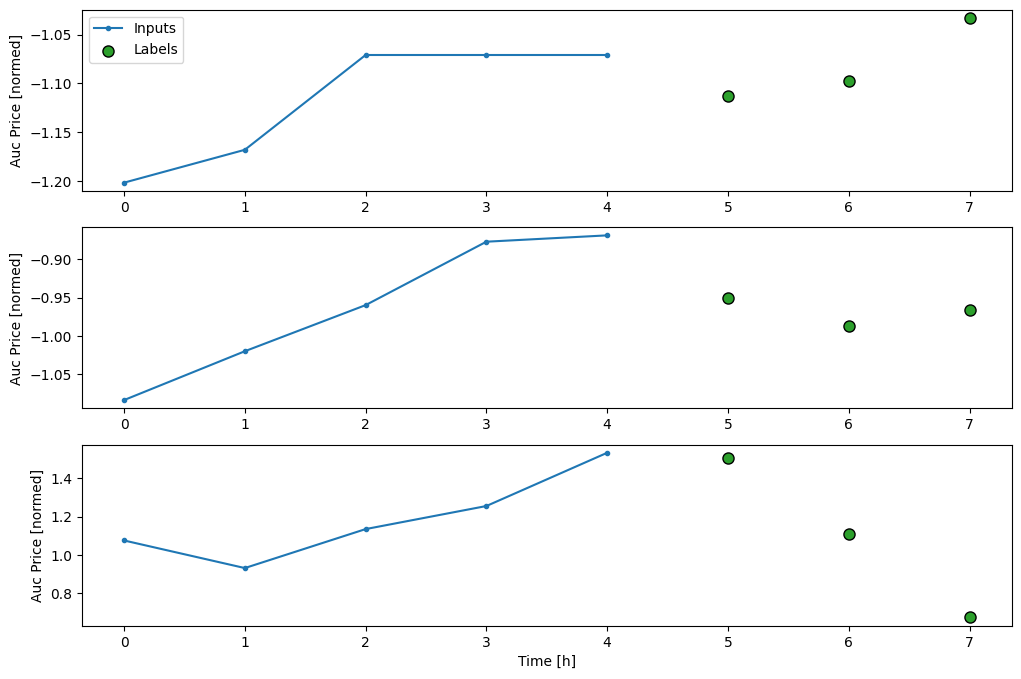

In [83]:
OUT_STEPS = 3

multi_window = WindowGenerator(input_width=5,
                               train_df=train_df, val_df=val_df, test_df=test_df,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

multi_window.plot()
multi_window

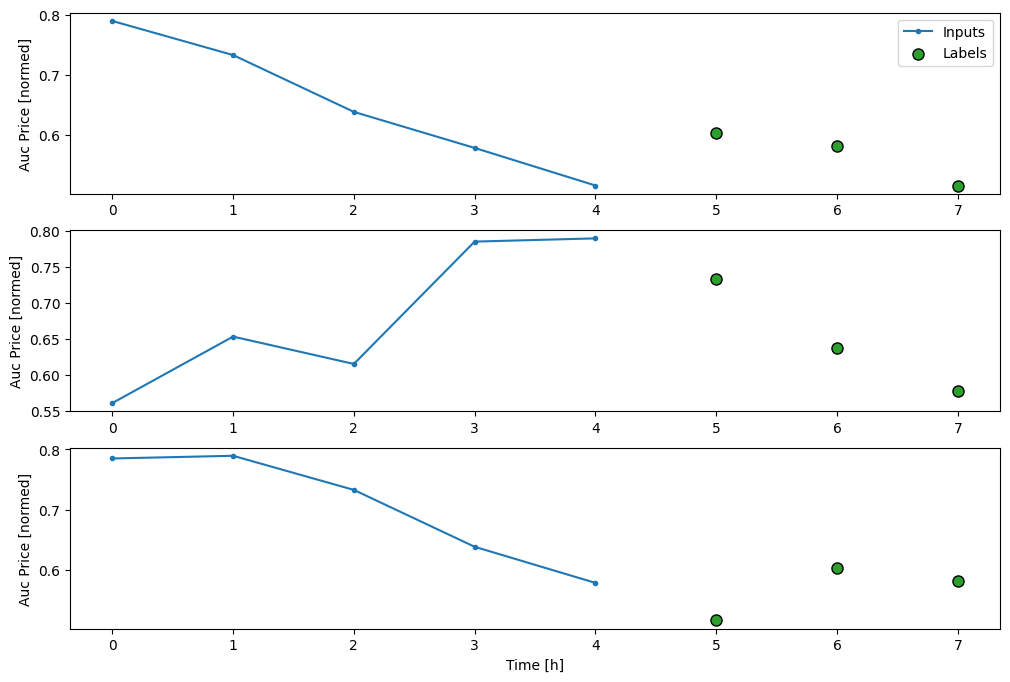

In [84]:
multi_window.plot_test()

In [85]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    train_df=train_df, test_df=test_df, val_df=val_df,
    label_columns=['Auc Price'])


single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['Auc Price']

In [86]:
val_performance = {}
performance = {}

In [87]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', linear(single_step_window.example[0]).shape)

history = preprocessor.compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val, return_dict=True)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0, return_dict=True)

Input shape: (32, 1, 22)
Output shape: (32, 1, 1)
Epoch 1/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.0483 - mean_absolute_error: 1.1889 - val_loss: 0.6808 - val_mean_absolute_error: 0.7051
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.8382 - mean_absolute_error: 1.1256 - val_loss: 0.5697 - val_mean_absolute_error: 0.6377
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.4204 - mean_absolute_error: 0.9732 - val_loss: 0.5109 - val_mean_absolute_error: 0.5863
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.6116 - mean_absolute_error: 1.0343 - val_loss: 0.4937 - val_mean_absolute_error: 0.5671
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.5803 - mean_absolute_error: 1.0255 - val_loss: 0.5132 - val_mean_absolute_error: 0.5881
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.4566 - mean_absolute_error: 0.9670 - val_loss: 0.5566 - val_mean_absolute_error: 0.6151
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.5566 - mean_absolute_error

In [74]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

Input shape: (32, 1, 18)
Output shape: (32, 1, 1)


In [91]:
CONV_WIDTH = 3
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    train_df=train_df, test_df=test_df, val_df=val_df,
    label_width=1,
    shift=1,
    label_columns=['Auc Price'])

conv_window



Epoch 1/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.2645 - mean_absolute_error: 0.9895 - val_loss: 0.8491 - val_mean_absolute_error: 0.8510
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7281 - mean_absolute_error: 0.7341 - val_loss: 0.4362 - val_mean_absolute_error: 0.6020
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4438 - mean_absolute_error: 0.5794 - val_loss: 0.0769 - val_mean_absolute_error: 0.2354
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2993 - mean_absolute_error: 0.4575 - val_loss: 0.1222 - val_mean_absolute_error: 0.2668
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1774 - mean_absolute_error: 0.3351 - val_loss: 0.0993 - val_mean_absolute_error: 0.2817
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1055 - mean_absolute_error: 0.2449 - val_loss: 0.1915 - val_mean_absolute_error: 0.3854
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0739 - mean_absolute_error: 0.2029 - val_loss: 0.1058 - val_mean_a

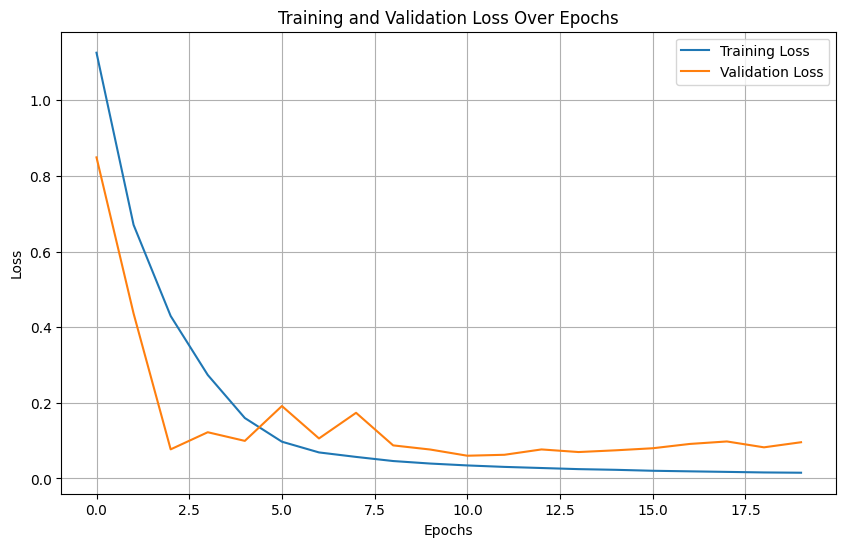

In [102]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])
history = preprocessor.compile_and_fit(conv_model, conv_window, use_early_stopping=False)

val_performance['Conv'] = conv_model.evaluate(conv_window.val, return_dict=True)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0, return_dict=True)

Plotting.plot_history(history)

Epoch 1/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.8190 - mean_absolute_error: 0.7289 - val_loss: 2.0834 - val_mean_absolute_error: 1.3502
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3583 - mean_absolute_error: 0.4806 - val_loss: 2.0226 - val_mean_absolute_error: 1.3328
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2328 - mean_absolute_error: 0.3759 - val_loss: 0.9454 - val_mean_absolute_error: 0.8615
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1257 - mean_absolute_error: 0.2755 - val_loss: 0.4890 - val_mean_absolute_error: 0.5709
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0870 - mean_absolute_error: 0.2257 - val_loss: 0.2428 - val_mean_absolute_error: 0.3971
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0656 - mean_absolute_error: 0.1902 - val_loss: 0.2133 - val_mean_absolute_error: 0.3804
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0618 - mean_absolute_error: 0.1850 - val_loss: 0.1862 - val_mean_a

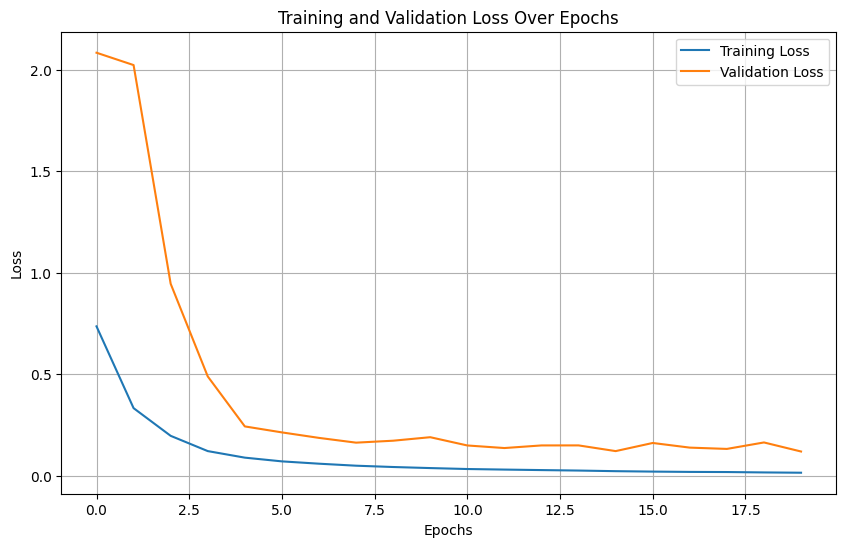

In [104]:
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])

history = preprocessor.compile_and_fit(multi_step_dense, conv_window, use_early_stopping=False)
val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val, return_dict=True)
performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test, verbose=0, return_dict=True)

Plotting.plot_history(history)

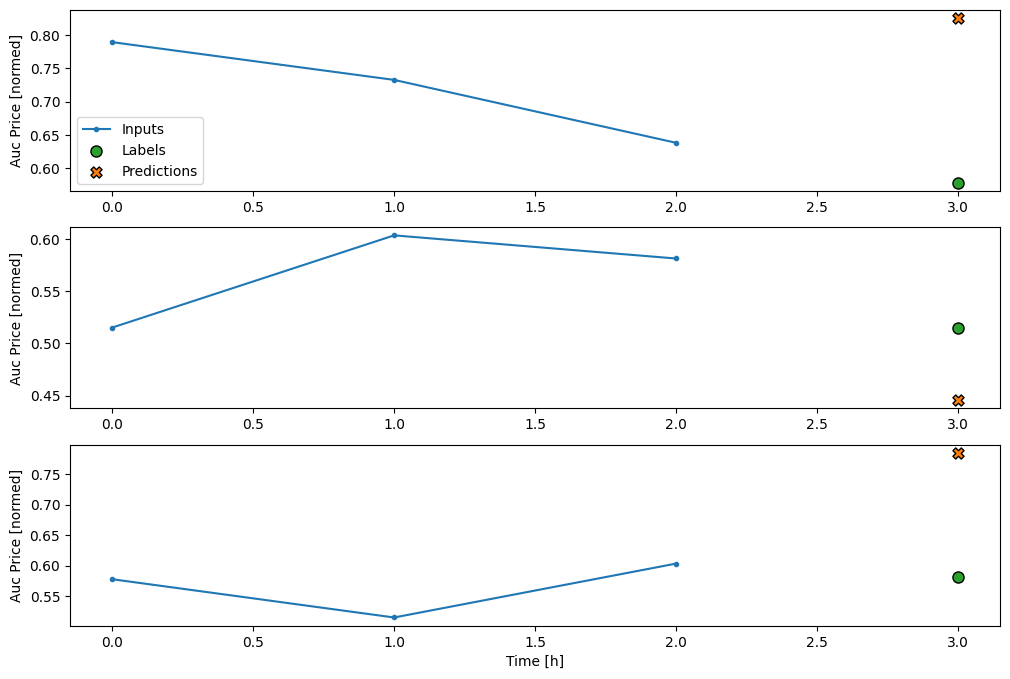

In [106]:
conv_window.plot_test(multi_step_dense, plot_col='Auc Price')

auction_df

In [81]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

print("Conv model on `conv_window`")
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', conv_model(conv_window.example[0]).shape)

Conv model on `conv_window`
Input shape: (32, 3, 18)
Output shape: (32, 1, 1)


In [82]:
history = compile_and_fit(conv_model, conv_window)

IPython.display.clear_output()
val_performance['Conv'] = conv_model.evaluate(conv_window.val, return_dict=True)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0, return_dict=True)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0782 - mean_absolute_error: 0.2413


In [83]:
LABEL_WIDTH = 3
CONV_WIDTH = 3
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)

In [84]:
INPUT_WIDTH

5

In [86]:
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    train_df=train_df, test_df=test_df, val_df=val_df,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=['Auc Price'])
print("Wide conv window")
print('Input shape:', wide_conv_window.example[0].shape)
print('Labels shape:', wide_conv_window.example[1].shape)
print('Output shape:', conv_model(wide_conv_window.example[0]).shape)

Wide conv window
Input shape: (32, 5, 18)
Labels shape: (32, 3, 1)
Output shape: (32, 3, 1)


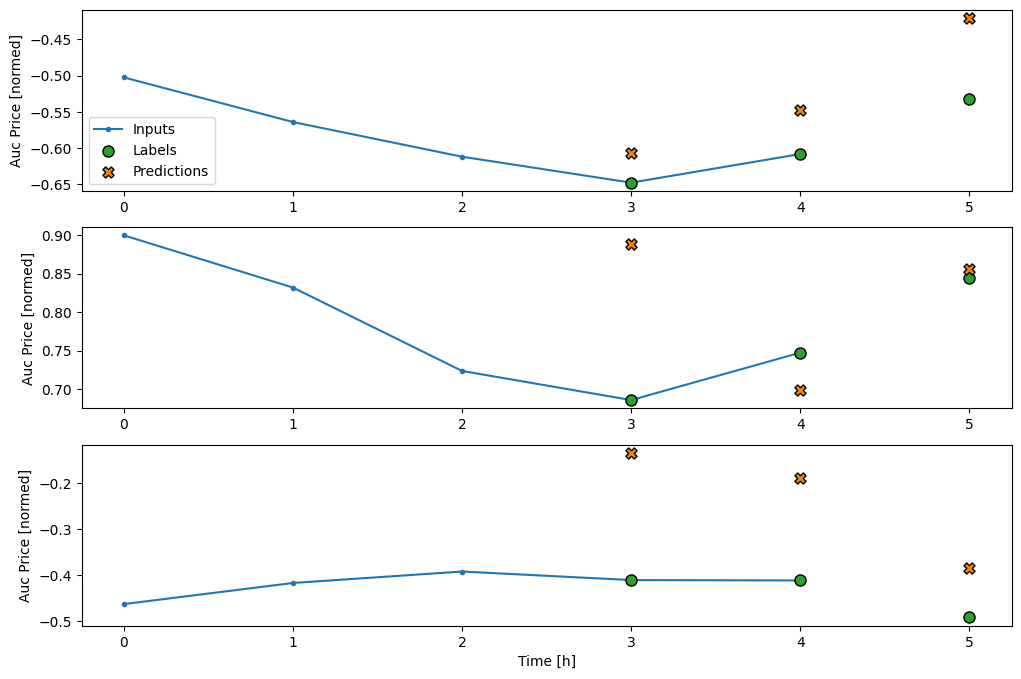

In [87]:
wide_conv_window.plot(conv_model)

## Modeling

### MultiStep Last Baseline

In [39]:
merged_df.head().to_csv(index=False)

'Date,Auc Price,Cover Ratio,Auction Spot Diff,Median Spot Diff,Premium/discount-settle,net_speculators,spec_long_%,spec_short_%,Long/Short,Pct_Change_Auc_Price,delta_auc,T-2,delta_auc_4,auc_T-2,auc_T-4,delta_ls,delta_ls_4,ls_T-2,ls_T-4\n2018-06-09,15.78,1.77,-0.09,-0.06999999999999851,0.0006373486297004462,50668.63,5.4,0.39,13.846153846153847,0.0,-0.3600000000000012,16.35,-0.5700000000000021,16.14,16.35,0.0,0.0,16.14,16.35\n2018-06-10,15.78,1.77,-0.09,-0.06999999999999851,0.0006373486297004462,50838.47,5.4,0.39,13.846153846153847,0.0,0.0,15.7,0.08000000000000007,15.78,15.7,0.0,0.0,15.78,15.7\n2018-06-11,15.7,2.03,0.01,-0.09999999999999964,0.0006373486297004462,50838.47,5.4,0.39,13.846153846153847,-0.5069708491761693,-0.08000000000000007,16.14,-0.4400000000000013,15.78,16.14,0.0,0.0,15.78,16.14\n2018-06-12,15.08,1.63,-0.12,-0.06999999999999851,-0.007894736842105263,50838.47,5.4,0.39,13.846153846153847,-3.9490445859872603,-0.6999999999999993,15.78,-0.6999999999999993,15.78,15.78,0.0,0.0,

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.3255 - mean_absolute_error: 0.2988


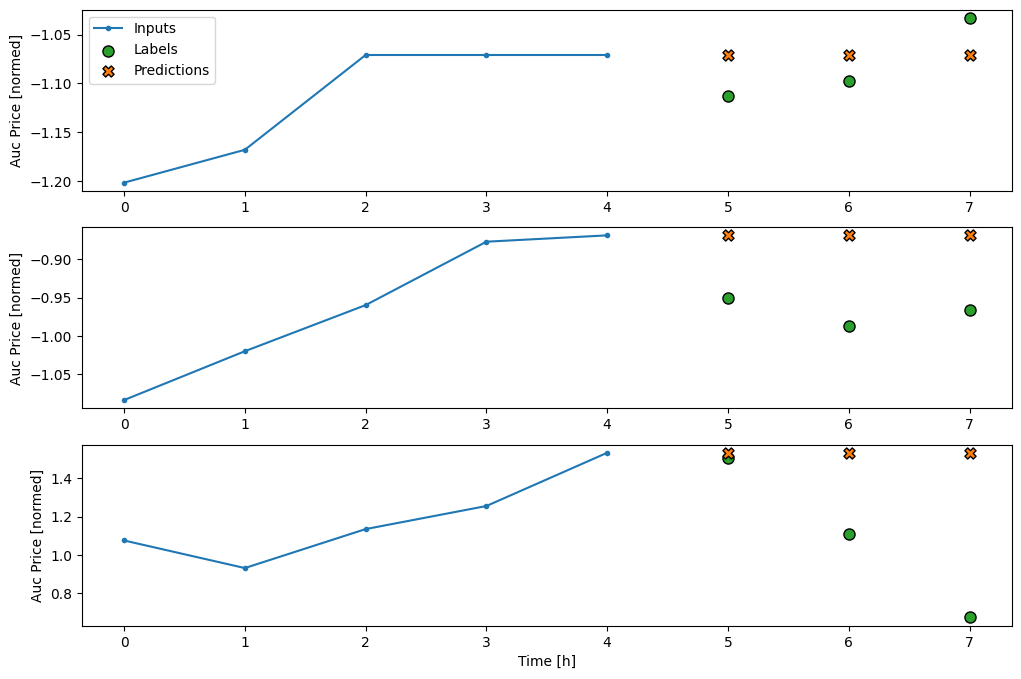

In [107]:
class MultiStepLastBaseline(tf.keras.Model):
  def call(self, inputs):
    return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])

last_baseline = MultiStepLastBaseline()
last_baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                      metrics=[tf.keras.metrics.MeanAbsoluteError()])

multi_val_performance = {}
multi_performance = {}

multi_val_performance['Last'] = last_baseline.evaluate(multi_window.val, return_dict=True)
multi_performance['Last'] = last_baseline.evaluate(multi_window.test, verbose=0, return_dict=True)
multi_window.plot(last_baseline)

### Multi Linear Model

In [111]:
len(test_df.columns)

22

Epoch 1/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.0136 - mean_absolute_error: 0.7644 - val_loss: 1.8971 - val_mean_absolute_error: 1.0379
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.9064 - mean_absolute_error: 0.7276 - val_loss: 1.8668 - val_mean_absolute_error: 1.0332
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.8300 - mean_absolute_error: 0.6936 - val_loss: 1.8602 - val_mean_absolute_error: 1.0399
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.8225 - mean_absolute_error: 0.6871 - val_loss: 1.8677 - val_mean_absolute_error: 1.0487
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.7920 - mean_absolute_error: 0.6689 - val_loss: 1.8788 - val_mean_absolute_error: 1.0576
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.7603 - mean_absolute_error: 0.6546 - val_loss: 1.8864 - val_mean_absolute_error: 1.0630
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.8097 - mean_absolute_error: 0.6667 - val_loss: 1.8874 - val_mean_a

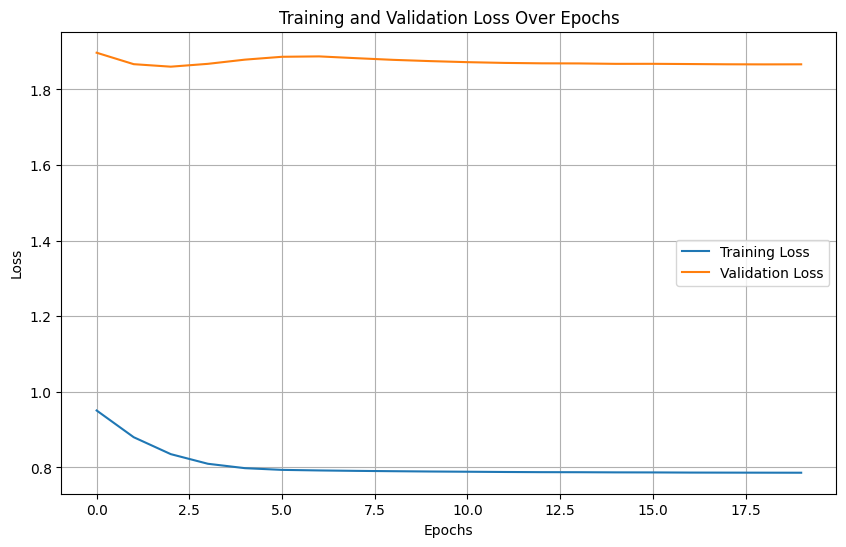

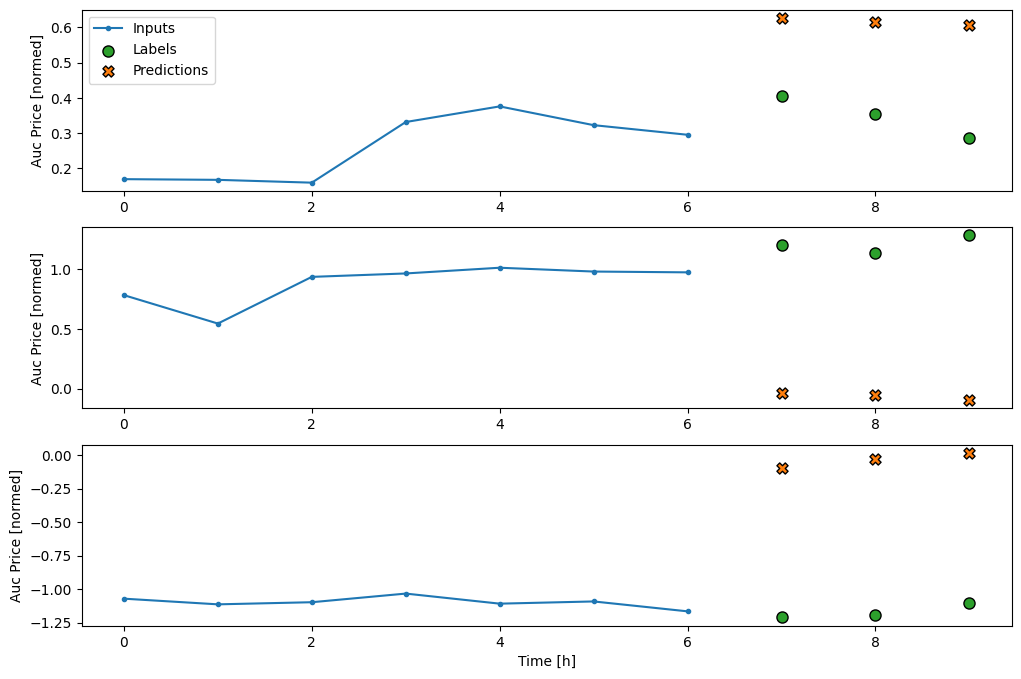

In [113]:

OUT_STEPS = 3
INPUT_STEPS = 7
multi_window = WindowGenerator(input_width=INPUT_STEPS,
                               train_df=train_df, val_df=val_df, test_df=test_df,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

multi_linear_model = tf.keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*1,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, 1])
])

history = preprocessor.compile_and_fit(multi_linear_model, multi_window, use_early_stopping=False)
multi_val_performance['Linear'] = multi_linear_model.evaluate(multi_window.val, return_dict=True)
multi_performance['Linear'] = multi_linear_model.evaluate(multi_window.test, verbose=1, return_dict=True)
Plotting.plot_history(history)
multi_window.plot(multi_linear_model)

In [116]:
num_features = len(test_df.columns)

### Dense Model

Epoch 1/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.8962 - mean_absolute_error: 0.7109 - val_loss: 0.9012 - val_mean_absolute_error: 0.7472
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5060 - mean_absolute_error: 0.4931 - val_loss: 0.6345 - val_mean_absolute_error: 0.6263
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4145 - mean_absolute_error: 0.4216 - val_loss: 0.3837 - val_mean_absolute_error: 0.4754
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3362 - mean_absolute_error: 0.3672 - val_loss: 0.3690 - val_mean_absolute_error: 0.4556
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2971 - mean_absolute_error: 0.3392 - val_loss: 0.3376 - val_mean_absolute_error: 0.4372
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2843 - mean_absolute_error: 0.3235 - val_loss: 0.2920 - val_mean_absolute_error: 0.3864
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2688 - mean_absolute_error: 0.3071 - val_loss: 0.2749 - val_mean_a

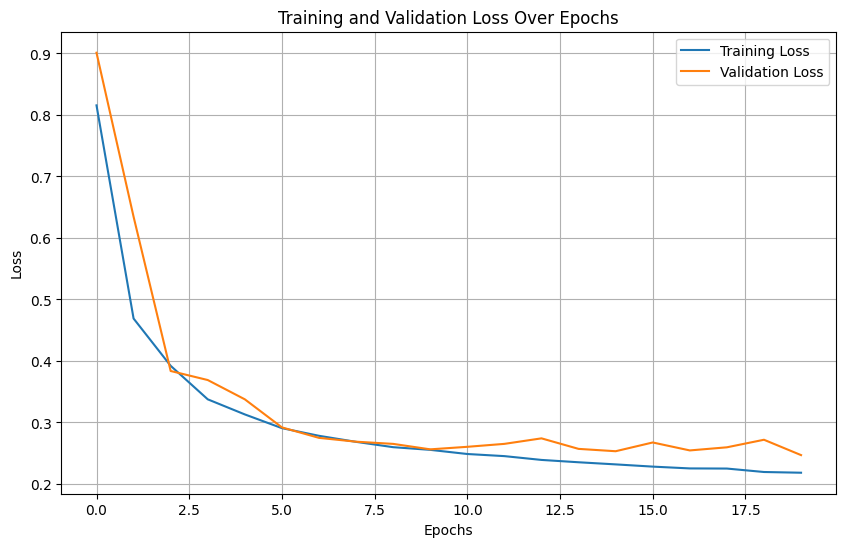

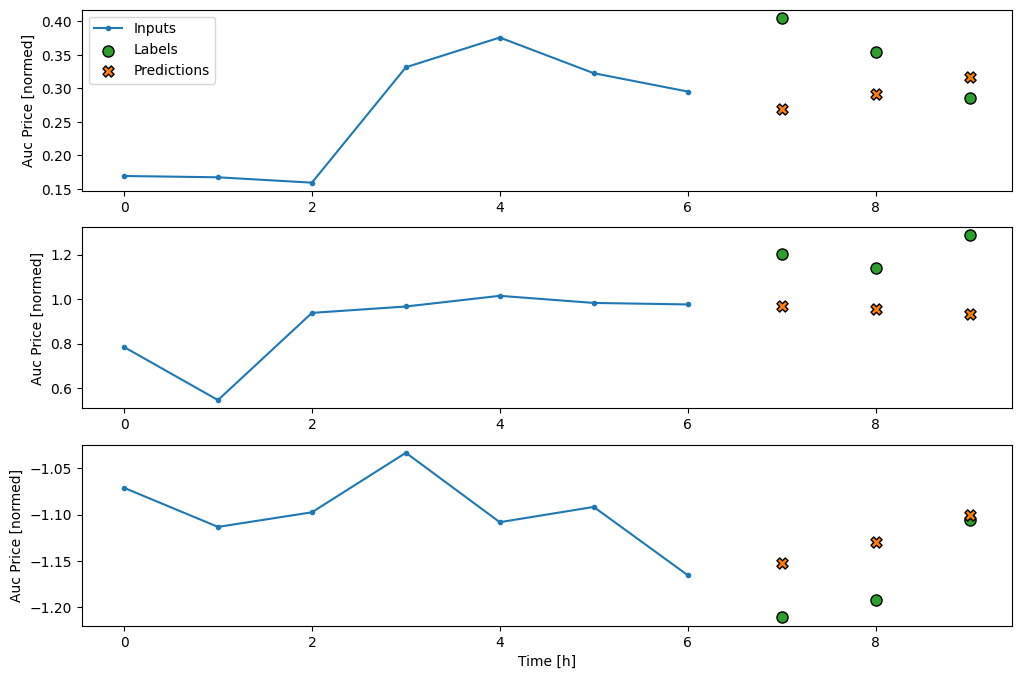

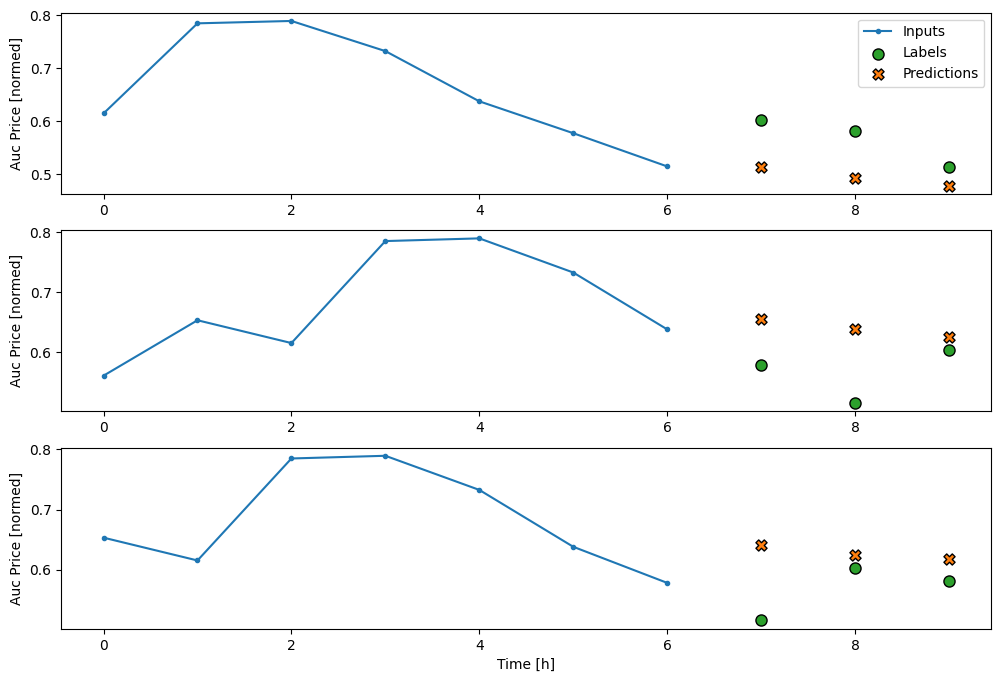

In [118]:
multi_dense_model = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(512, activation='relu'),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = preprocessor.compile_and_fit(multi_dense_model, multi_window, use_early_stopping=False)
multi_val_performance['Dense'] = multi_dense_model.evaluate(multi_window.val, return_dict=True)
multi_performance['Dense'] = multi_dense_model.evaluate(multi_window.test, verbose=1, return_dict=True)
Plotting.plot_history(history)
multi_window.plot(multi_dense_model)
multi_window.plot_test(multi_dense_model)

### Conv Model

Epoch 1/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5486 - mean_absolute_error: 0.4771 - val_loss: 0.3517 - val_mean_absolute_error: 0.2971
Epoch 2/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3000 - mean_absolute_error: 0.2657 - val_loss: 0.3277 - val_mean_absolute_error: 0.2770
Epoch 3/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2737 - mean_absolute_error: 0.2463 - val_loss: 0.3098 - val_mean_absolute_error: 0.2680
Epoch 4/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2579 - mean_absolute_error: 0.2389 - val_loss: 0.3010 - val_mean_absolute_error: 0.2620
Epoch 5/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2423 - mean_absolute_error: 0.2306 - val_loss: 0.2940 - val_mean_absolute_error: 0.2576
Epoch 6/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2394 - mean_absolute_error: 0.2295 - val_loss: 0.2886 - val_mean_absolute_error: 0.2553
Epoch 7/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2256 - mean_absolute_error: 0.2259 - val_loss: 0.282

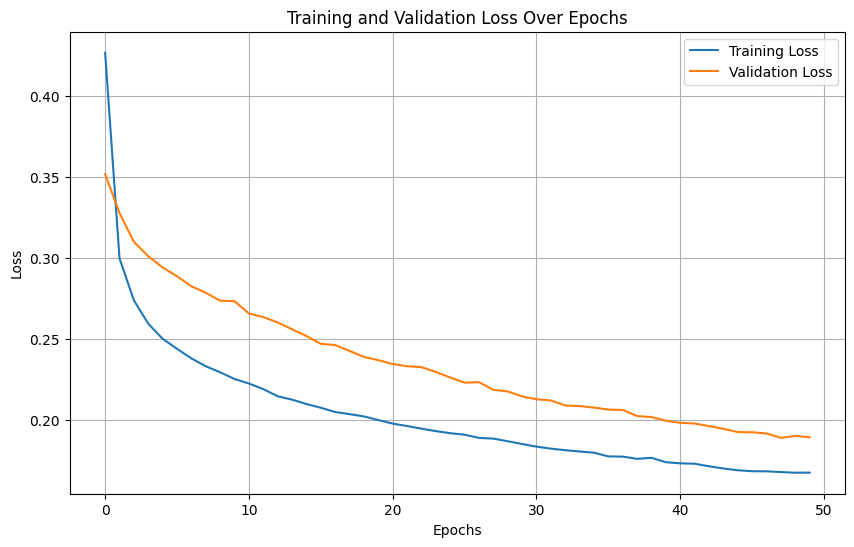

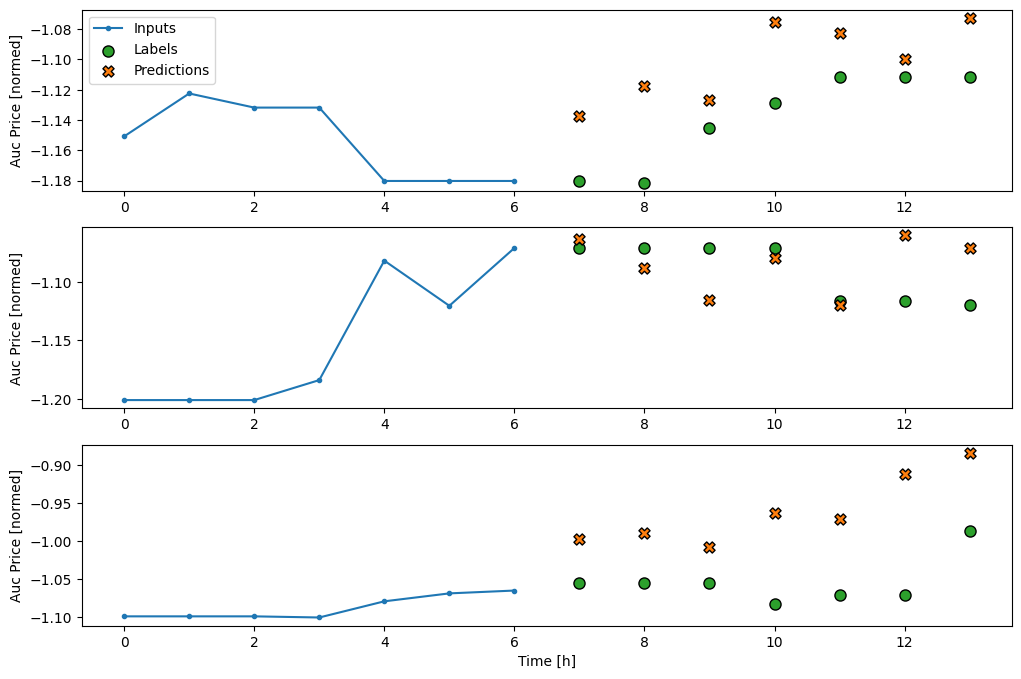

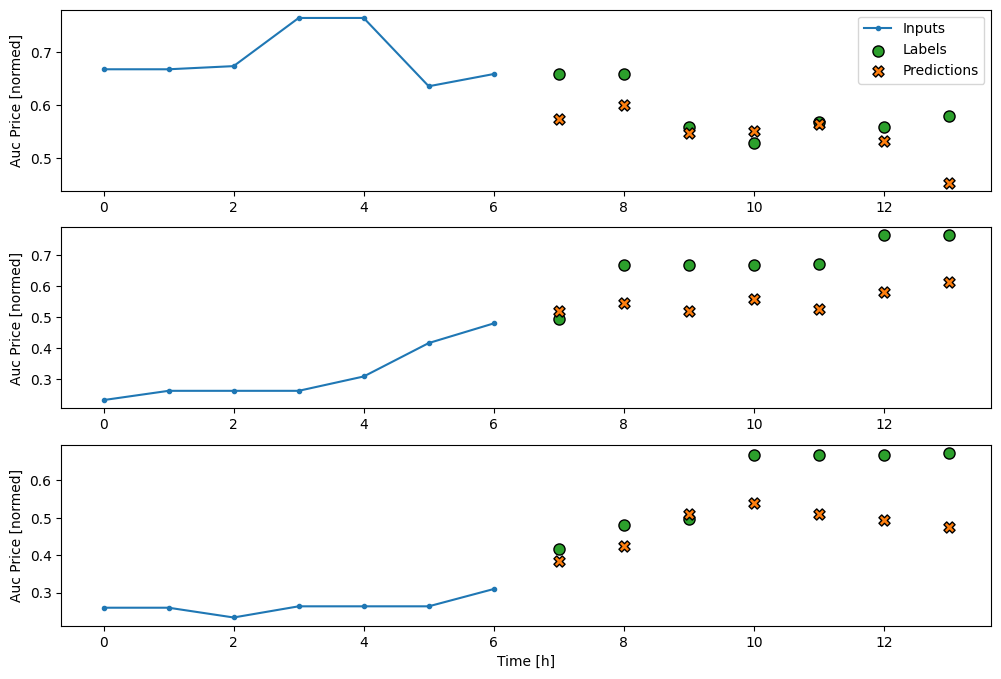

In [13]:
OUT_STEPS = 7
multi_window = WindowGenerator(input_width=7,
                               train_df=train_df, val_df=val_df, test_df=test_df,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

CONV_WIDTH = 3
multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = preprocessor.compile_and_fit(multi_conv_model, multi_window, use_early_stopping=True, max_epochs=50)
# multi_val_performance['Multi Conv'] = multi_conv_model.evaluate(multi_window.val, return_dict=True)
# multi_performance['Multi Conv'] = multi_conv_model.evaluate(multi_window.test, verbose=1, return_dict=True)
Plotting.plot_history(history)
multi_window.plot(multi_conv_model)
multi_window.plot_test(multi_conv_model)

### Multi-step LSTM Model

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


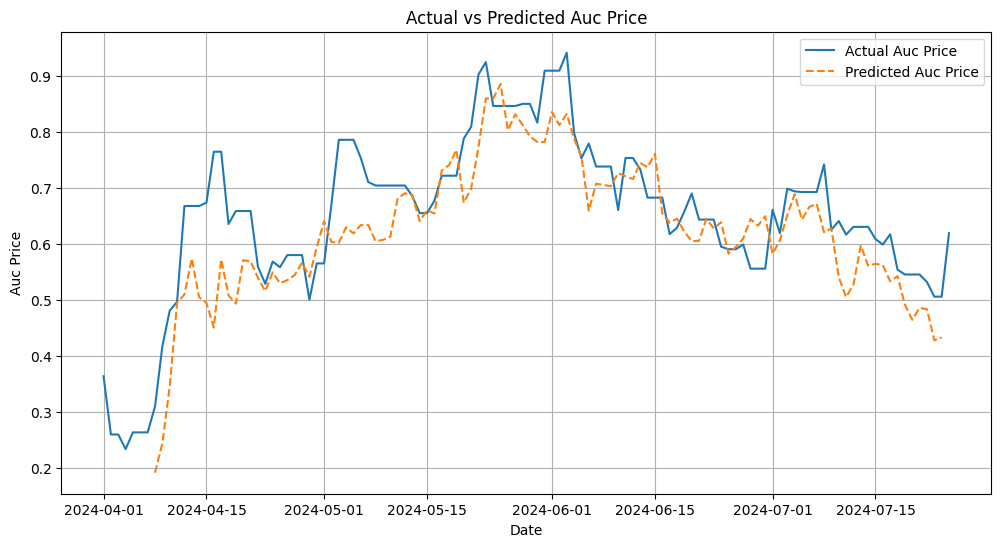

In [10]:

sequential_predict_and_plot(multi_conv_model, test_df, 7, 3, test_df.columns)

In [185]:
from utils.dataset import DataPreprocessor, Plotting

Epoch 1/50


/Users/zeerakwyne/Documents/freelance/Carbon-Market-Forecasting/utils/dataset.py:404: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged_df = merged_df.fillna(method='bfill').fillna(method='ffill')


66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.8165 - mean_absolute_error: 0.6800 - val_loss: 0.5346 - val_mean_absolute_error: 0.4408
Epoch 2/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4628 - mean_absolute_error: 0.3798 - val_loss: 0.4808 - val_mean_absolute_error: 0.4017
Epoch 3/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4300 - mean_absolute_error: 0.3566 - val_loss: 0.4274 - val_mean_absolute_error: 0.3672
Epoch 4/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3857 - mean_absolute_error: 0.3302 - val_loss: 0.3878 - val_mean_absolute_error: 0.3347
Epoch 5/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3551 - mean_absolute_error: 0.3082 - val_loss: 0.3709 - val_mean_absolute_error: 0.3153
Epoch 6/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3243 - mean_absolute_error: 0.2903 - val_loss: 0.3623 - val_mean_absolute_error: 0.3074
Epoch 7/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3249 - mean_absolute_error: 0.2862 - val_loss: 0.3547 - val_mea

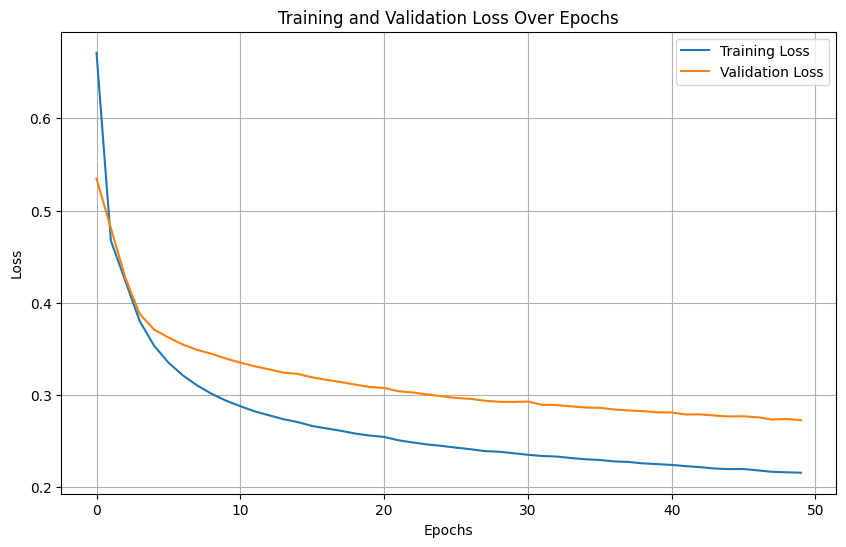

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


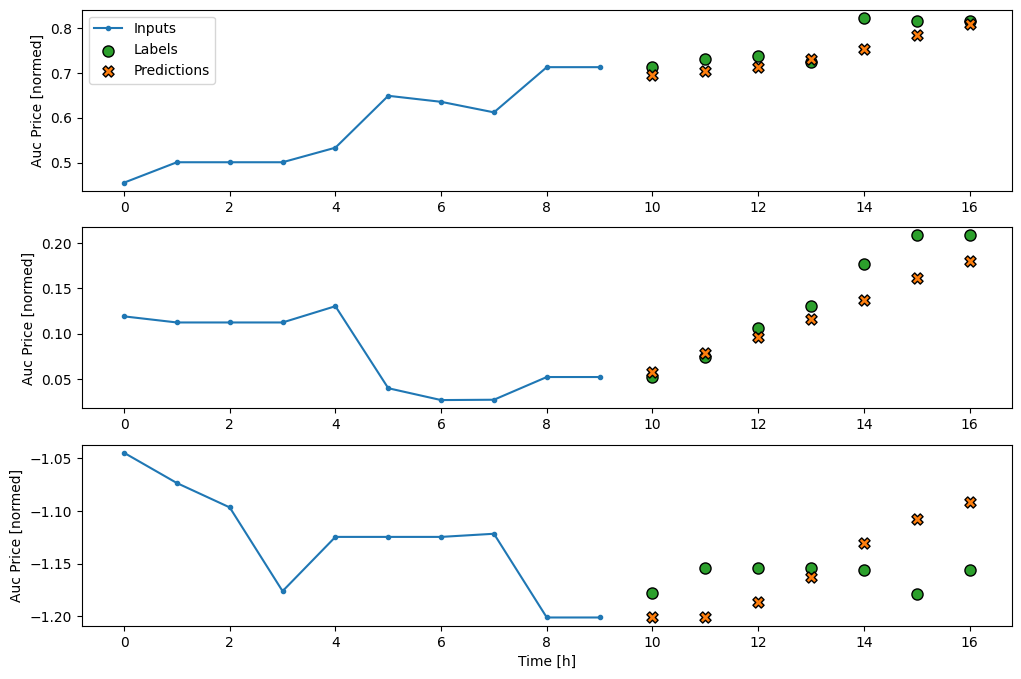

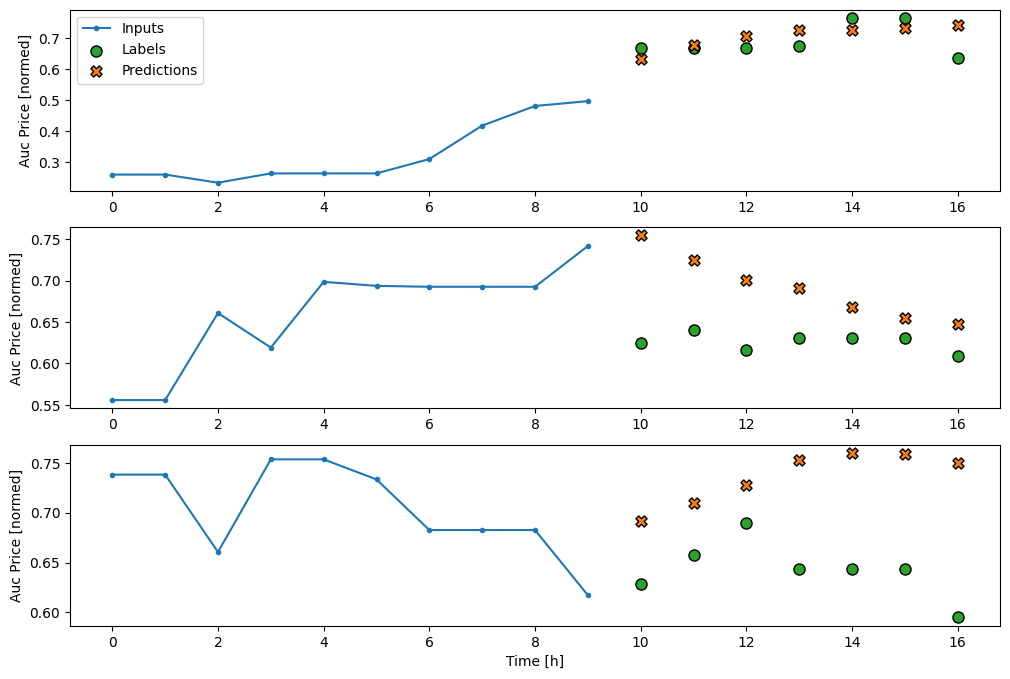

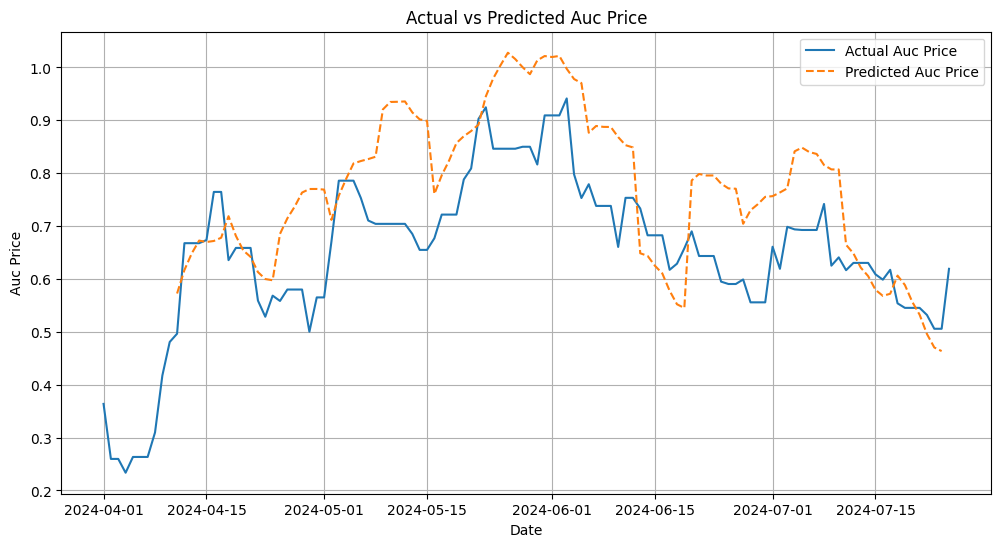

In [38]:
def sequential_predict_and_plot(model, test_df, input_width, out_steps, features):
    num_features = len(features)
    predictions = []
    inputs = test_df.iloc[:input_width].values

    for i in range(input_width, len(test_df) - out_steps + 1, out_steps):
        inputs = inputs[-input_width:]
        if inputs.shape[0] != input_width or inputs.shape[1] != num_features:
            raise ValueError(f"Expected input shape ({input_width}, {num_features}), but got {inputs.shape}")
        inputs_reshaped = inputs.reshape((1, input_width, num_features))
        preds = model.predict(inputs_reshaped)
        predictions.append(preds[0])
        # inputs = np.concatenate([inputs, preds[0]])
        inputs = np.concatenate([inputs, test_df.iloc[i:i+out_steps].values])

    predictions = np.concatenate(predictions, axis=0)
    predictions_df = pd.DataFrame(predictions, columns=features, index=test_df.index[input_width:input_width + len(predictions)])

    plt.figure(figsize=(12, 6))
    plt.plot(test_df.index, test_df['Auc Price'], label='Actual Auc Price')
    plt.plot(predictions_df.index, predictions_df['Auc Price'], label='Predicted Auc Price', linestyle='dashed')
    plt.xlabel('Date')
    plt.ylabel('Auc Price')
    plt.title('Actual vs Predicted Auc Price')
    plt.legend()
    plt.grid(True)
    plt.show()

# cot_df, auction_df, eua_df, ta_df, fundamentals_df = MarketData.latest(Path('data'))
# cot_df = cot_df.set_index('Date').resample('W', origin='end').mean().reset_index()
# auction_df = auction_df.set_index('Date').resample('D').mean().reset_index()

# # Merge and preprocess data
# merged_df = MarketData.merge_auc_cot(auction_df, cot_df)
# merged_df = DataPreprocessor.MA_features(merged_df)


# merged_df = merged_df.dropna()

cot_df, auction_df, eua_df, ta_df, fundamentals_df = MarketData.latest(Path('data'))
cot_df = cot_df.set_index('Date').resample('W', origin='end').mean().reset_index()
auction_df = auction_df.set_index('Date').resample('D').mean().reset_index()

auction_df = auction_df[7:]

merged_df = DataPreprocessor.engineer_auction_features(auction_df)
# Define features and labels
FEATURES = merged_df.columns.tolist()
LABEL_COLS = ['Auc Price']

# Initialize DataPreprocessor
preprocessor = DataPreprocessor(features=FEATURES, label_columns=LABEL_COLS, input_width=7, label_width=7, shift=1)
train_df, test_df, val_df = preprocessor.train_test_data(merged_df)
train_df, test_df, val_df = preprocessor.normalize(train_df, test_df, val_df)
num_features = len(test_df.columns)


OUT_STEPS = 7
INPUT_WIDTH = 10
multi_window = WindowGenerator(input_width=INPUT_WIDTH,
                               train_df=train_df, val_df=val_df, test_df=test_df,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

multi_lstm_model = tf.keras.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=False),
    tf.keras.layers.Dense(OUT_STEPS*num_features,kernel_initializer=tf.initializers.zeros()),
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])
history = preprocessor.compile_and_fit(multi_lstm_model, multi_window, use_early_stopping=False, max_epochs=50)

Plotting.plot_history(history)
multi_window.plot(multi_lstm_model)
multi_window.plot_test(multi_lstm_model)

# Sequentially predict and plot the test data
sequential_predict_and_plot(multi_lstm_model, test_df, input_width=INPUT_WIDTH, out_steps=OUT_STEPS, features=test_df.columns)

#### Inference & Plotting


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Prev Auc Price: 0.48082473717634633
Pred Difference: 0.16634068049485728
Prev Auc Price: 0.7646348378171615
Pred Difference: -0.12086044759651937
Prev Auc Price: 0.5684664896738384
Pred Difference: 0.17573868715645335
Prev Auc Price: 0.5651099970249986
Pred Difference: 0.22889414525939467
Prev Auc Price: 0.7042179701380389
Pred Difference: 0.21607637428716253
Prev Auc Price: 0.6549894112883841
Pred Difference: 0.1848958831490244
Prev Auc Pr

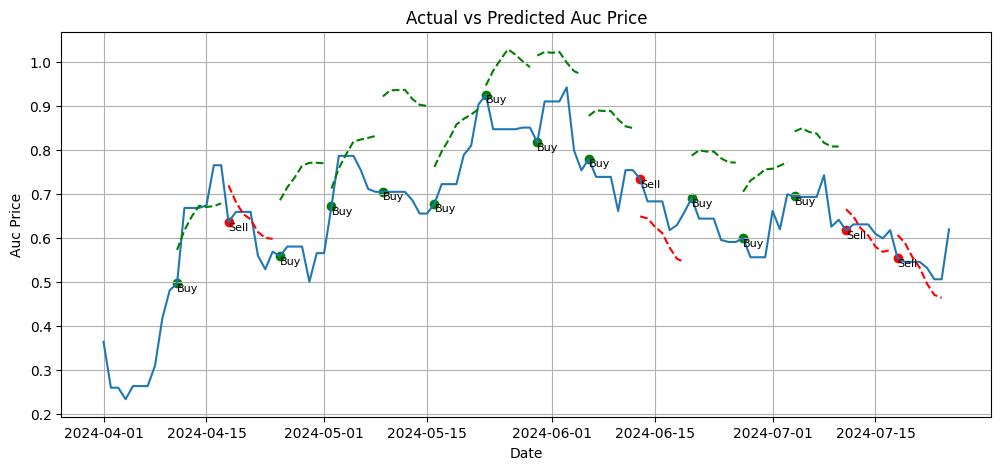

In [39]:
model = multi_lstm_model
# model = multi_conv_model
test_df = test_df
# input_width = 14
input_width = INPUT_WIDTH
# out_steps = OUT_STEPS
out_steps = 7
features = test_df.columns

num_features = len(features)
predictions = []
inputs = test_df.iloc[:input_width].values
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Assuming `model`, `test_df`, `input_width`, `out_steps`, `num_features`, and `features` are already defined

predictions = []
colors = plt.cm.viridis(np.linspace(0, 1, len(range(input_width, len(test_df) - out_steps + 1, out_steps))))

for idx, i in enumerate(range(input_width, len(test_df) - out_steps + 1, out_steps)):


    # multi_window = WindowGenerator(input_width=7,
    #                            train_df=train_df, val_df=val_df, test_df=test_df,
    #                            label_width=OUT_STEPS,
    #                            shift=OUT_STEPS)
    
    # history = preprocessor.compile_and_fit(multi_lstm_model, multi_window, use_early_stopping=False, max_epochs=100)
    try:    
        inputs = test_df[i-input_width:i].values
        inputs_reshaped = inputs.reshape((1, input_width, num_features))
        

        preds = model.predict(inputs_reshaped)
        predictions.append(preds[0])
        inputs = np.concatenate([inputs, test_df[i:i+out_steps].values])
    except Exception as e:
        break
predictions = np.concatenate(predictions, axis=0)
predictions_df = pd.DataFrame(predictions, columns=features, index=test_df.index[input_width:input_width + len(predictions)])

plt.figure(figsize=(12, 5))
plt.plot(test_df.index, test_df['Auc Price'], label='Actual Auc Price')

def check_gradient(values):
    gradient = np.gradient(values)
    return 'positive' if np.all(gradient > 0) else 'negative'

for idx, i in enumerate(range(input_width, len(test_df) - out_steps + 1, out_steps)):
    
    trend = check_gradient(predictions_df['Auc Price'][idx* out_steps:(idx+1)* out_steps].values)
    # pred_start_data = predictions_df.index[idx* out_steps:(idx+1)* out_steps][0]

    single_point_index = predictions_df.index[idx* out_steps:(idx+1)* out_steps][0]  # Example index
    single_point_value = test_df[test_df.index == single_point_index]['Auc Price'].values[0]  # Example value
    # plt.scatter(single_point_index, single_point_value, color='red')
    # plt.text(single_point_index, single_point_value, trend, fontsize=8, verticalalignment='bottom')

    prev_timestamp = single_point_index - pd.to_timedelta(1, unit='d')
    prev_auc_price = test_df[test_df.index == prev_timestamp]['Auc Price'].values[0]
    pred_diff = np.mean(predictions_df['Auc Price'][idx* out_steps:(idx+1)* out_steps].values) - prev_auc_price
    print(f"Prev Auc Price: {prev_auc_price}")
    print(f"Pred Difference: {pred_diff}")
    if pred_diff > 0:
        plt.scatter(single_point_index, single_point_value, color='green', marker='o')
        plt.text(single_point_index, single_point_value, "Buy", fontsize=8, verticalalignment='top')
        plt.plot(predictions_df.index[idx* out_steps:(idx+1)* out_steps], 
             predictions_df['Auc Price'][idx* out_steps:(idx+1)* out_steps], 
             label=f'Predicted Auc Price {idx+1}', linestyle='dashed', color='green')
    else: 
        plt.scatter(single_point_index, single_point_value, color='red', marker='o')
        plt.text(single_point_index, single_point_value, "Sell", fontsize=8, verticalalignment='top')
        plt.plot(predictions_df.index[idx* out_steps:(idx+1)* out_steps], 
             predictions_df['Auc Price'][idx* out_steps:(idx+1)* out_steps], 
             label=f'Predicted Auc Price {idx+1}', linestyle='dashed', color='red')

    # plt.plot(predictions_df.index[idx* out_steps:(idx+1)* out_steps], 
    #          predictions_df['Auc Price'][idx* out_steps:(idx+1)* out_steps], 
    #          label=f'Predicted Auc Price {idx+1}', linestyle='dashed', color=colors[idx])

# inputs = test_df.iloc[-input_width:].values
# inputs_reshaped = inputs.reshape((1, input_width, num_features))
# preds = model.predict(inputs_reshaped)
# predictions = []
# predictions.append(preds[0])
# predictions = np.concatenate(predictions, axis=0)
# predictions_df = pd.DataFrame(predictions, columns=features, index=test_df.iloc[-OUT_STEPS:].index)
# trend = check_gradient(predictions_df['Auc Price'].values)
# single_point_index = predictions_df.index[0]  # Example index
# single_point_value = test_df[test_df.index == single_point_index]['Auc Price'].values[0]

# plt.text(single_point_index, single_point_value, trend, fontsize=8, verticalalignment='bottom')
# plt.plot(predictions_df.index, 
#              predictions_df['Auc Price'], 
#              label=f'RECENT Auc Price', linestyle='dashed', color='red')


plt.xlabel('Date')
plt.ylabel('Auc Price')
plt.title('Actual vs Predicted Auc Price')
# plt.legend()
plt.grid(True)
plt.show()

In [22]:
preds[0].shape

(7, 71)

In [144]:
multi_window = WindowGenerator(input_width=7,
                               train_df=train_df, val_df=val_df, test_df=test_df,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)


7

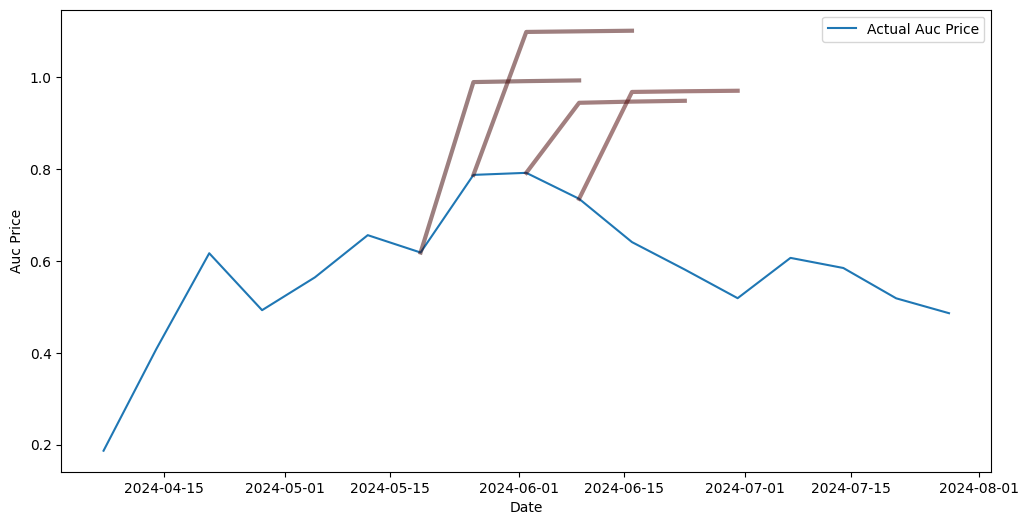

In [143]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming train_mean and train_std are the mean and std used during training
train_mean = train_df.mean()
train_std = train_df.std()

# Normalize the test data
test_df_normalized = (test_df - train_mean) / train_std

plt.figure(figsize=(12, 6))
plt.plot(test_df.index, test_df['Auc Price'], label='Actual Auc Price')

for i in range(0, test_df_normalized.shape[0], 1):
    if i < INPUT_STEPS or i > test_df_normalized.shape[0] - INPUT_STEPS: continue
    
    inputs = test_df_normalized[i - INPUT_STEPS: i].copy()
    outputs = test_df[i - 1: i + OUT_STEPS].copy()
    colors = plt.cm.hot(np.linspace(0, 1, 100))
    
    data = np.array(inputs, dtype=np.float32)
    predictions = multi_lstm_model(data.reshape(1, INPUT_STEPS, test_df_normalized.shape[1]))
    
    for j in range(OUT_STEPS):
        outputs.iloc[j + 1, :] = np.array(predictions[0][j]) * train_std + train_mean  # Denormalize the predictions
    
    plt.plot(outputs.index, outputs['Auc Price'], color=colors[i % 100], alpha=0.5, linewidth=3)

plt.xlabel('Date')
plt.ylabel('Auc Price')
plt.legend()
plt.show()


In [146]:
data.reshape(1, INPUT_STEPS, test_df_normalized.shape[1]).shape

(1, 7, 22)

### Feedback Model

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 597us/step - loss: 0.7562 - mean_absolute_error: 0.5216


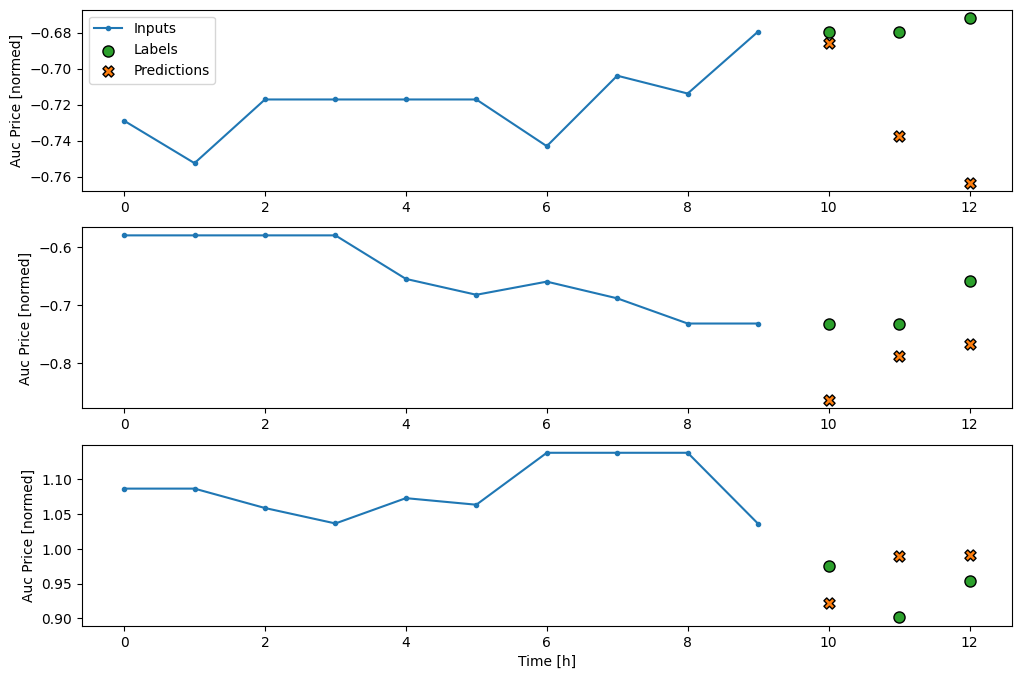

In [42]:
OUT_STEPS = 3
multi_window = WindowGenerator(input_width=10,
                               train_df=train_df, val_df=val_df, test_df=test_df,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)


class FeedBack(tf.keras.Model):
  def __init__(self, units, out_steps):
    super().__init__()
    self.out_steps = out_steps
    self.units = units
    self.lstm_cell = tf.keras.layers.LSTMCell(units)
    # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
    self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
    self.dense = tf.keras.layers.Dense(num_features)
    
def warmup(self, inputs):
  # inputs.shape => (batch, time, features)
  # x.shape => (batch, lstm_units)
  x, *state = self.lstm_rnn(inputs)

  # predictions.shape => (batch, features)
  prediction = self.dense(x)
  return prediction, state


def call(self, inputs, training=None):
  # Use a TensorArray to capture dynamically unrolled outputs.
  predictions = []
  # Initialize the LSTM state.
  prediction, state = self.warmup(inputs)

  # Insert the first prediction.
  predictions.append(prediction)

  # Run the rest of the prediction steps.
  for n in range(1, self.out_steps):
    # Use the last prediction as input.
    x = prediction
    # Execute one lstm step.
    x, state = self.lstm_cell(x, states=state,
                              training=training)
    # Convert the lstm output to a prediction.
    prediction = self.dense(x)
    # Add the prediction to the output.
    predictions.append(prediction)

  # predictions.shape => (time, batch, features)
  predictions = tf.stack(predictions)
  # predictions.shape => (batch, time, features)
  predictions = tf.transpose(predictions, [1, 0, 2])
  return predictions

feedback_model = FeedBack(units=32, out_steps=OUT_STEPS)
FeedBack.call = call
FeedBack.warmup = warmup

prediction, state = feedback_model.warmup(multi_window.example[0])
prediction.shape

print('Output shape (batch, time, features): ', feedback_model(multi_window.example[0]).shape)


history = compile_and_fit(feedback_model, multi_window)

IPython.display.clear_output()

multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val, return_dict=True)
multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose=0, return_dict=True)
multi_window.plot(feedback_model)

### Advanced AR LSTM

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.1321 - mean_absolute_error: 0.6978


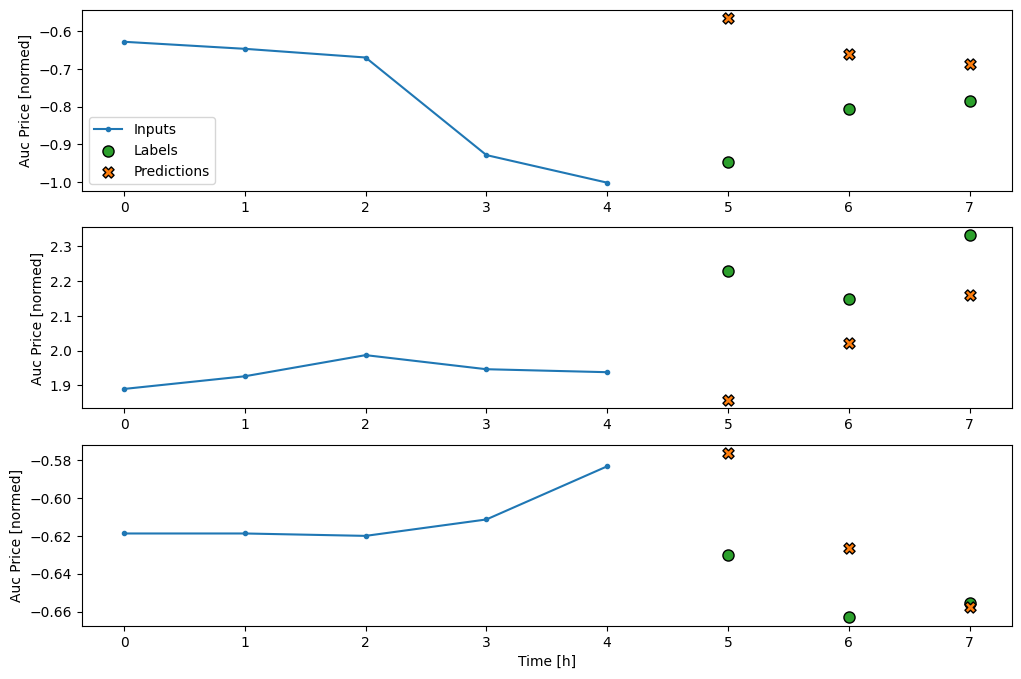

In [270]:
merged_df = merge_auc_cot(auction_df, cot_df)
train_df, test_df, val_df = train_test_data(merged_df)
train_df, test_df, val_df = normalize(train_df, test_df, val_df)
num_features = train_df.shape[1]    

OUT_STEPS = 3
INPUT_STEPS = 5
multi_window = WindowGenerator(input_width=INPUT_STEPS,
                               train_df=train_df, val_df=val_df, test_df=test_df,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

class AdvancedFeedBack(tf.keras.Model):
    def __init__(self, units, out_steps, num_features):
        super().__init__()
        self.out_steps = out_steps
        self.units = units
        self.lstm_cell = tf.keras.layers.LSTMCell(units)
        self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
        
        # Bidirectional LSTM layer
        self.bidirectional_lstm = tf.keras.layers.Bidirectional(
            tf.keras.layers.LSTM(units, return_sequences=True))
        
        # Attention mechanism
        self.attention = tf.keras.layers.Attention()
        
        # Dense layers with dropout and residual connections
        self.dense1 = tf.keras.layers.Dense(units, activation='relu')
        self.dropout = tf.keras.layers.Dropout(0.3)
        self.dense = tf.keras.layers.Dense(num_features)
        
    def warmup(self, inputs):
        x, *state = self.lstm_rnn(inputs)
        prediction = self.dense(x)
        return prediction, state
    
    def call(self, inputs, training=None):
        predictions = []
        prediction, state = self.warmup(inputs)
        predictions.append(prediction)

        for n in range(1, self.out_steps):
            x = prediction
            x, state = self.lstm_cell(x, states=state, training=training)
            x = self.bidirectional_lstm(x)
            
            # Attention mechanism
            context_vector, attention_weights = self.attention([x, x], return_attention_scores=True)
            x = context_vector
            
            # Dense layers with residual connection
            x = self.dense1(x)
            x = self.dropout(x, training=training)
            prediction = self.dense(x)
            predictions.append(prediction)

        predictions = tf.stack(predictions)
        predictions = tf.transpose(predictions, [1, 0, 2])
        return predictions

advanced_feedback_model = AdvancedFeedBack(units=64, out_steps=OUT_STEPS, num_features=num_features)
AdvancedFeedBack.call = call
AdvancedFeedBack.warmup = warmup

prediction, state = advanced_feedback_model.warmup(multi_window.example[0])
print('Output shape (batch, time, features): ', advanced_feedback_model(multi_window.example[0]).shape)

history = compile_and_fit(advanced_feedback_model, multi_window)

IPython.display.clear_output()

multi_val_performance['Advanced AR LSTM'] = advanced_feedback_model.evaluate(multi_window.val, return_dict=True)
multi_performance['Advanced AR LSTM'] = advanced_feedback_model.evaluate(multi_window.test, verbose=0, return_dict=True)
multi_window.plot(advanced_feedback_model)

In [263]:
test_df = merged_df[merged_df['Date'].dt.year >= 2023].set_index('Date')

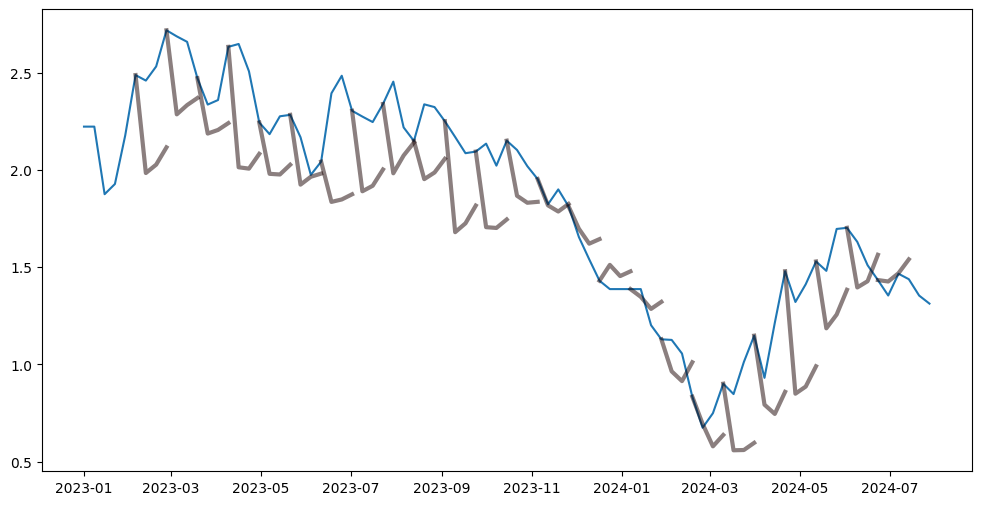

In [271]:
plt.figure(figsize=(12, 6))
plt.plot(test_df.index, test_df['Auc Price'])
for i in range(0, test_df.shape[0], 3):
    if i < INPUT_STEPS or i > test_df.shape[0]-INPUT_STEPS: continue
    inputs = test_df[i-INPUT_STEPS: i].copy()
    outputs = test_df[i-1: i+OUT_STEPS].copy()
    colors = plt.cm.hot(np.linspace(0, 1, 100))
    
    data = np.array(inputs, dtype=np.float32)
    predictions = advanced_feedback_model(data.reshape(1, INPUT_STEPS, test_df.shape[1]))
    for i in range(OUT_STEPS):
        outputs.iloc[i+1, :] = np.array(predictions[0][i])
    plt.plot(outputs.index, outputs['Auc Price'], color=colors[i], alpha=0.5, linewidth=3)
    # break

plt.show()

### Advanced AR LSTM with Multi-Head Attention

In [238]:
train_df.columns

['Auc Price', 'Cover Ratio',
       'Premium/discount-settle', 'net_speculators', 'spec_long_%',
       'spec_short_%', 'Long/Short', 'Pct_Change_Auc_Price', 'delta_auc',
       'delta_auc_4', 'auc_T-2', 'auc_T-4', 'delta_ls', 'delta_ls_4', 'ls_T-2',
       'ls_T-4']

['Auc Price',
 'Cover Ratio',
 'Premium/discount-settle',
 'net_speculators',
 'spec_long_%',
 'spec_short_%',
 'Long/Short',
 'Pct_Change_Auc_Price',
 'delta_auc',
 'delta_auc_4',
 'auc_T-2',
 'auc_T-4',
 'delta_ls',
 'delta_ls_4',
 'ls_T-2',
 'ls_T-4']

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.2287 - mean_absolute_error: 0.7592


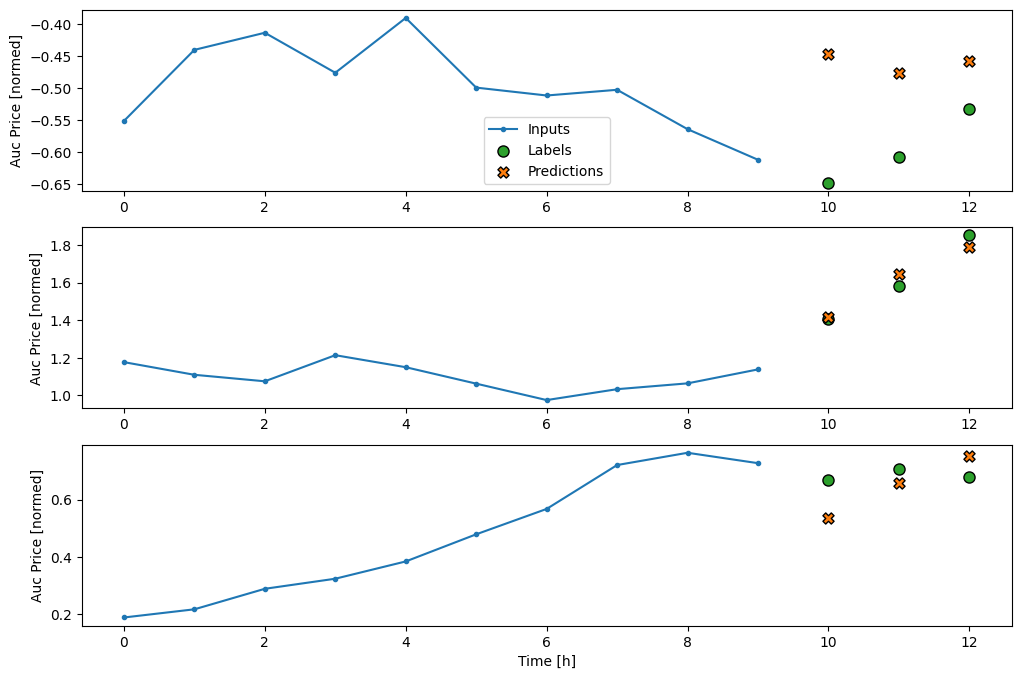

In [272]:
# merged_df = merge_auc_cot(auction_df, cot_df)
# features = ['Auc Price', 'Cover Ratio',
#        'Premium/discount-settle', 'net_speculators', 'spec_long_%',
#        'spec_short_%', 'Long/Short', 'Pct_Change_Auc_Price', 'delta_auc',
#        'delta_auc_4', 'auc_T-2', 'auc_T-4', 'delta_ls', 'delta_ls_4', 'ls_T-2',
#        'ls_T-4']

# train_df, test_df, val_df = train_test_data(merged_df, features=features)
# train_df, test_df, val_df = normalize(train_df, test_df, val_df)
# num_features = train_df.shape[1]    

# OUT_STEPS = 3
# multi_window = WindowGenerator(input_width=10,
#                                train_df=train_df, val_df=val_df, test_df=test_df,
#                                label_width=OUT_STEPS,
#                                shift=OUT_STEPS)


merged_df = merge_auc_cot(auction_df, cot_df)
train_df, test_df, val_df = train_test_data(merged_df)
train_df, test_df, val_df = normalize(train_df, test_df, val_df)
num_features = train_df.shape[1]    

OUT_STEPS = 3
INPUT_STEPS = 10
multi_window = WindowGenerator(input_width=INPUT_STEPS,
                               train_df=train_df, val_df=val_df, test_df=test_df,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)



class AdvancedFeedBack(tf.keras.Model):
    def __init__(self, units, out_steps, num_features, num_heads=4):
        super().__init__()
        self.out_steps = out_steps
        self.units = units
        self.lstm_cell = tf.keras.layers.LSTMCell(units)
        self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
        
        # Bidirectional LSTM layer
        self.bidirectional_lstm = tf.keras.layers.Bidirectional(
            tf.keras.layers.LSTM(units, return_sequences=True))
        
        # Multi-head attention mechanism
        # self.multi_head_attention = tf.keras.layers.MultiHeadAttention(
        #     num_heads=num_heads, key_dim=units)
        
        # Dense layers with dropout and residual connections
        self.dense1 = tf.keras.layers.Dense(units, activation='relu')
        self.dropout = tf.keras.layers.Dropout(0.3)
        self.dense = tf.keras.layers.Dense(num_features)
        
    def warmup(self, inputs):
        x, *state = self.lstm_rnn(inputs)
        prediction = self.dense(x)
        return prediction, state
    
    def call(self, inputs, training=None):
        predictions = []
        prediction, state = self.warmup(inputs)
        predictions.append(prediction)

        for n in range(1, self.out_steps):
            x = prediction
            x, state = self.lstm_cell(x, states=state, training=training)
            x = self.bidirectional_lstm(x)
            
            # Multi-head attention mechanism
            x = self.multi_head_attention(query=x, value=x)
            
            # Dense layers with residual connection
            x = self.dense1(x)
            x = self.dropout(x, training=training)
            prediction = self.dense(x)
            predictions.append(prediction)

        predictions = tf.stack(predictions)
        predictions = tf.transpose(predictions, [1, 0, 2])
        return predictions

advanced_feedback_model = AdvancedFeedBack(units=64, out_steps=OUT_STEPS, num_features=num_features, num_heads=4)
AdvancedFeedBack.call = call
AdvancedFeedBack.warmup = warmup

prediction, state = advanced_feedback_model.warmup(multi_window.example[0])
print('Output shape (batch, time, features): ', advanced_feedback_model(multi_window.example[0]).shape)

history = compile_and_fit(advanced_feedback_model, multi_window)

IPython.display.clear_output()

multi_val_performance['Advanced AR LSTM with Multi-Head Attention'] = advanced_feedback_model.evaluate(multi_window.val, return_dict=True)
multi_performance['Advanced AR LSTM with Multi-Head Attention'] = advanced_feedback_model.evaluate(multi_window.test, verbose=0, return_dict=True)
multi_window.plot(advanced_feedback_model)

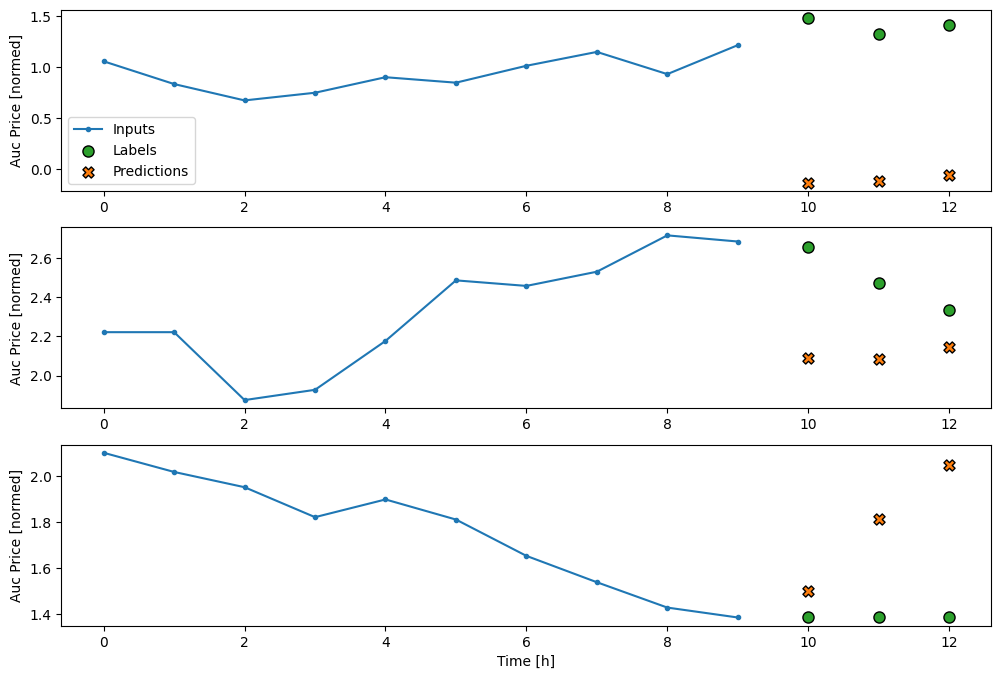

In [273]:
multi_window.plot_test(advanced_feedback_model)

In [245]:
test_df.shape

(53, 16)

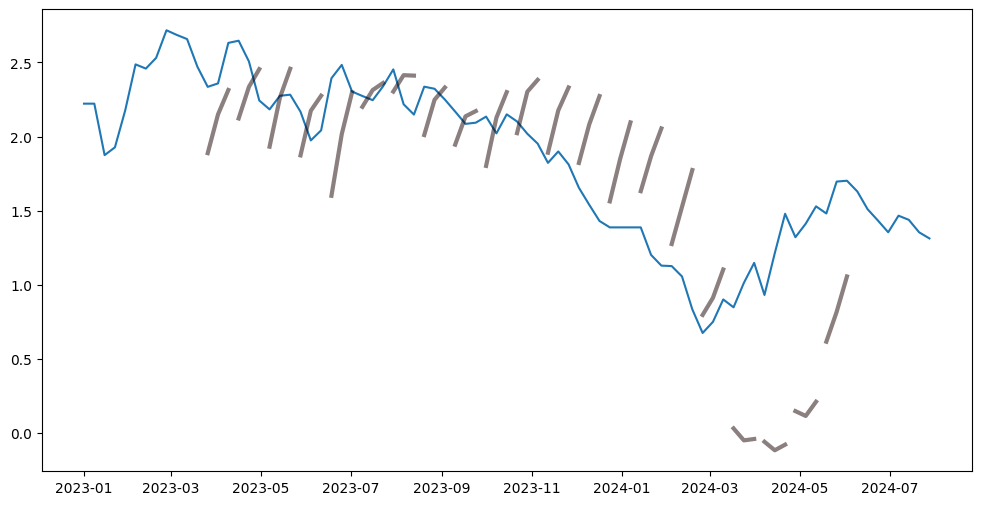

In [275]:
plt.figure(figsize=(12, 6))
plt.plot(test_df.index, test_df['Auc Price'])
for i in range(0, test_df.shape[0], 3):
    if i < INPUT_STEPS or i > test_df.shape[0]-INPUT_STEPS: continue
    inputs = test_df[i-INPUT_STEPS: i].copy()
    outputs = test_df[i: i+OUT_STEPS].copy()
    colors = plt.cm.hot(np.linspace(0, 1, 100))
    
    data = np.array(inputs, dtype=np.float32)
    predictions = advanced_feedback_model(data.reshape(1, INPUT_STEPS, test_df.shape[1]))
    for i in range(OUT_STEPS):
        outputs.iloc[i, :] = np.array(predictions[0][i])
    plt.plot(outputs.index, outputs['Auc Price'], color=colors[i], alpha=0.5, linewidth=3)
    # break

plt.show()

In [ ]:
# Define the LSTM model
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(50, activation='relu', input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])),
    tf.keras.layers.Dense(1)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model
history = model.fit(X_train_scaled, y_train, epochs=50, batch_size=32, validation_data=(X_test_scaled, y_test), verbose=2, shuffle=False)

# Evaluate the model
test_loss, test_mae = model.evaluate(X_test_scaled, y_test, verbose=0)
print(f'Test MAE: {test_mae}')

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


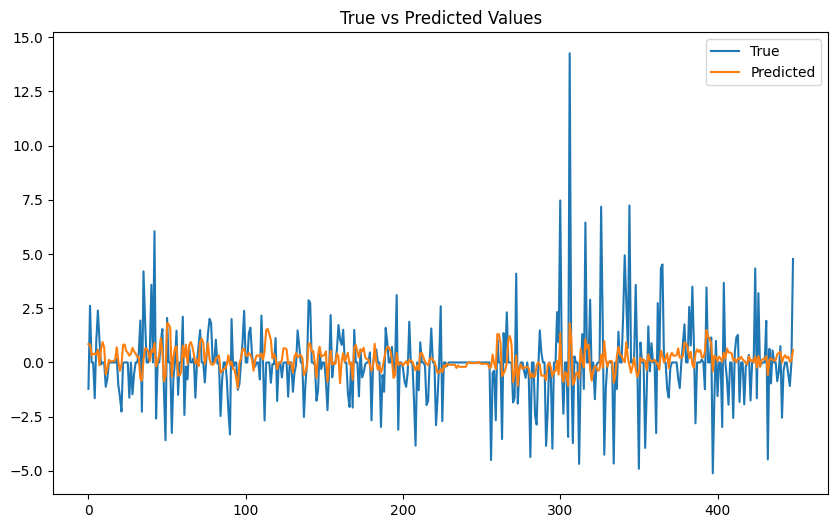

In [58]:
# Make predictions
y_pred = model.predict(X_test_scaled)

# Plot the results
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.plot(y_test, label='True')
plt.plot(y_pred, label='Predicted')
plt.title('True vs Predicted Values')
plt.legend()
plt.show()

In [64]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, AdditiveAttention, Permute, Reshape, Multiply

model = Sequential()

# Adding LSTM layers with return_sequences=True
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50, return_sequences=True))
# Adding self-attention mechanism
# The attention mechanism
attention = AdditiveAttention(name='attention_weight')
# Permute and reshape for compatibility
model.add(Permute((2, 1))) 
model.add(Reshape((-1, X_train.shape[1])))
attention_result = attention([model.output, model.output])
multiply_layer = Multiply()([model.output, attention_result])
# Return to original shape
model.add(Permute((2, 1))) 
model.add(Reshape((-1, 50)))

# Adding a Flatten layer before the final Dense layer
model.add(tf.keras.layers.Flatten())

# Final Dense layer
model.add(Dense(1))

ValueError: The layer sequential_2 has never been called and thus has no defined output.